<a id="title_ID"></a>
# Pixel-based ACS/WFC CTE Forward Model

This notebook demonstrates preparing data for input into the ACS/WFC pixel-based CTE forward model and running the model.

### Table of Contents

[Introduction](#intro_ID) <br>
[0. Install/update stenv](#update) <br>
[1. Imports](#imports) <br>
[2. Download data and reference files](#download) <br>
[3. Create an image of artificial stars](#stars) <br>

[Option A: Start with an observed FLC image](#option-a)
 - [4. Add artificial stars](#A4)
 - [5. Reverse the flat and dark correction](#A5)
 - [6. Run CTE forward model](#A6)
 - [7. (Optional) Run CTE correction](#A7)
 - [8. Apply flat and dark correction](#A8) <br>
 
[Option B: Start with a synthetic image](#option-b)
 - [4. Create your image](#B4)
 - [5. Run CTE forward model](#B5)
 - [6. (Optional) Run CTE correction](#B6)
 - [7. Apply flat and dark correction](#B7) <br>

[About this Notebook](#about_ID)

<a id="intro_ID"></a>
## Introduction

The charge transfer efficiency (CTE) of the Advanced Camera for Surveys (ACS) Wide Field Channel (WFC) has been decreasing over the lifetime of the instrument. Radiation damage from cosmic rays and other sources leads to charge traps within the detector. These traps remove electrons from charge packets as they are transferred between rows of the detector, and release the electrons in subsequent pixels. This causes flux to be removed from bright features and released into pixels behind the features (relative to the row closest to the amplifier), creating bright trails.

A pixel-based CTE correction model for the ACS/WFC detector is fully described in [Anderson & Bedin (2010)](https://ui.adsabs.harvard.edu/abs/2010PASP..122.1035A/abstract), and a recent update to the model is presented in [ACS ISR 2018-04](http://www.stsci.edu/files/live/sites/www/files/home/hst/instrumentation/acs/documentation/instrument-science-reports-isrs/_documents/isr1804.pdf). The model is based on an empirical determination of the number and depth of charge traps distributed across the detector. It simulates detector readout of an input image, removes the result from the input, and iterates five times. In this way, a reverse model is successively approximated by the forward model. Electrons released in trails are removed and added back to the bright feature in which they originated.

The pixel-based correction was implemented in the calibration pipeline code for ACS (`CALACS`) in 2012 and the algorithm was updated and improved in 2018. The CTE correction step within `CALACS` runs on bias-corrected images, `blv_tmp` files, producing `blc_tmp` files, which lack the bright trails due to poor CTE. Further calibration, including dark correction and flat-fielding, produces `flt` and `flc` files from the `blv_tmp` and `blc_tmps` files, respectively. For more information on calibration of ACS/WFC data, see the [ACS Data Handbook](http://www.stsci.edu/files/live/sites/www/files/home/hst/instrumentation/acs/documentation/other-documents/_documents/acs_dhb.pdf).

Users desiring to more fully understand the effects of pixel-based CTE correction on their science may wish to run the forward model (i.e., the detector readout simulation) on data containing artificial stars. Here we demonstrate two methods for running the CTE forward model. In [Option A](#option-a), we begin with an observed `flc` image, whereas in [Option B](#option-b), we begin with a `raw` image and generate synthetic data on which to run the forward model.

**Note: The forward model, like the CTE correction step in `CALACS`, adds 10% of the difference between the input and output `SCI` extensions to the `ERR` extensions to account for uncertainty in the CTE model. Below, we provide guidance for properly repopulating the `ERR` extensions of forward-modeled data.**

<a id="update"></a>
### 0. Install/update stenv

#### *[AstroConda](https://astroconda.readthedocs.io/en/latest/) is no longer supported and is superseded by stenv.
[stenv](https://stenv.readthedocs.io/en/latest/) will include most packages from AstroConda and is recommended to process and analyze data from the Hubble Space Telescope (HST) and James Webb Space Telescope (JWST). To install and activate stenv, please refer to the [documentation](https://stenv.readthedocs.io/en/latest/getting_started.html). NOTE: stenv requires Python 3.8 or greater.

If you already use stenv, make sure the versions of `hstcal` and [`acstools`](https://acstools.readthedocs.io/en/latest/) are both at least 2.1.0. The version of `CALACS` should be at least 10.1.0. Check the versions of all three on the command line:

`$ conda list hstcal`

`$ conda list acstools`

`$ calacs.e --version`

It is recommended, however, that you use the most up-to-date versions of these packages. To update these packages, run the following via the command line:

`$ conda update hstcal`

`$ conda update acstools` 

<a id="imports"></a>
### 1. Imports

Start by importing several packages:

- *matplotlib notebook* for creating interactive plots
- *os* for setting environment variables
- *shutil* for managing directories
- *numpy* for math and array calculations
- *matplotlib pyplot* for plotting
- *matplotlib.colors LogNorm* for scaling images
- *astropy.io fits* for working with FITS files
- *photutils datasets* for creating synthetic stars and images
- *astroquery.mast Observations* for downloading data from MAST
- *acstools acsccd* for performing bias correction
- *acstools acscte* for performing CTE correction (reversing CTE trailing)
- *acstools acs2d* for performing dark correction and flat-fielding
- *acstools acscteforwardmodel* for running CTE forward model (generating CTE trailing)

In [1]:
import os
import shutil
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits
from astropy.modeling.models import Gaussian2D
from photutils.datasets import make_noise_image, make_model_params, make_model_image
from astroquery.mast import Observations
from acstools import acsccd
from acstools import acscte
from acstools import acs2d
from acstools import acscteforwardmodel

/opt/hostedtoolcache/Python/3.11.10/x64/lib/python3.11/site-packages/acstools/utils_findsat_mrt.py:24: UserWarning: skimage not installed. MRT calculation will not work: ModuleNotFoundError("No module named 'skimage'")
  warnings.warn(f'skimage not installed. MRT calculation will not work: {repr(e)}')  # noqa


[Top of Page](#title_ID)

<a id="download"></a>
### 2. Download data and reference files

Full-frame, new-mode subarray, and 2K old-mode subarray ACS/WFC images can be run through the CTE forward model. New-mode subarrays were added to the HST flight software at the beginning of Cycle 24. These subarrays have `APERTURE` keywords of the type `WFC1A-512, WFC1A-1K, WFC1A-2K`, etc. Old-mode subarrays have `APERTURE` keywords of the type `WFC1-512, WFC1-1K, WFC1-2K`, etc. WFC apertures are also listed in [Table 7.7 of the ACS IHB](https://hst-docs.stsci.edu/display/ACSIHB/7.7+ACS+Apertures#id-7.7ACSApertures-table7.7).

We recommend that the CTE forward model be run on data that has been bias-corrected, but not dark-corrected or flat-fielded. The flat and dark should be present in the image input into the CTE forward model because these features are present in the image when it is read out, and are therefore affected by CTE losses. The forward model can be run on `flc` files, but the results will technically be incorrect. Photometric tests of forward modeled data of both types show minor differences. Post-SM4 subarray data must be destriped with [`acs_destripe_plus`](https://acstools.readthedocs.io/en/latest/api/acstools.acs_destripe_plus.destripe_plus.html#acstools.acs_destripe_plus.destripe_plus),  which will also perform the other calibration steps. **Note: At this time, `acs_destripe_plus` only produces `flt`/`flc` images.**

We download a full-frame 47 Tuc image, `jd0q14ctq`, from the ACS CCD Stability Monitor program (PI: Coe, 14402) from the Mikulski Archive for Space Telescopes ([MAST](https://mast.stsci.edu/portal/Mashup/Clients/Mast/Portal.html)) using [astroquery](https://astroquery.readthedocs.io/en/latest/). This image was taken in March 2016, and so it is strongly affected by CTE losses. We download the `flc` image for [Option A](#option-a) and the `raw` image for [Option B](#option-b) into the current directory.

In [2]:
obs_table = Observations.query_criteria(obs_id='jd0q14ctq')

dl_table = Observations.download_products(obs_table['obsid'], mrp_only=False,
                                          productSubGroupDescription=['FLC', 'RAW'])

for row in dl_table:
    oldfname = row['Local Path']
    unique_fname = np.unique(oldfname)
    newfname = os.path.basename(oldfname)
    print(row)
    os.rename(oldfname, newfname)
    
shutil.rmtree('mastDownload')

 [Done]


 [Done]


 [Done]


                                             Local Path                                              Status  Message URL 
--------------------------------------------------------------------------------------------------- -------- ------- ----
./mastDownload/HST/hst_14402_14_acs_wfc_f775w_jd0q14ct/hst_14402_14_acs_wfc_f775w_jd0q14ct_flc.fits COMPLETE    None None
                   Local Path                    Status  Message URL 
----------------------------------------------- -------- ------- ----
./mastDownload/HST/jd0q14ctq/jd0q14ctq_flc.fits COMPLETE    None None
                   Local Path                    Status  Message URL 
----------------------------------------------- -------- ------- ----
./mastDownload/HST/jd0q14ctq/jd0q14ctq_raw.fits COMPLETE    None None


Next, update and download the correct flat and dark reference files for the `jd0q14ctq` dataset from the [Calibration Reference Data System](https://hst-crds.stsci.edu/) (CRDS). We use the [CRDS command line tools](https://hst-crds.stsci.edu/static/users_guide/command_line_tools.html#crds-bestrefs) to do this.

In [3]:
os.environ['CRDS_SERVER'] = 'https://hst-crds.stsci.edu'
os.environ['CRDS_PATH'] = './crds_cache'
os.environ['jref'] = './crds_cache/references/hst/acs/'

!crds bestrefs --update-bestrefs --sync-references=1 --files jd0q14ctq_flc.fits

CRDS - INFO -  Fetching  ./crds_cache/mappings/hst/hst_wfpc2_wf4tfile_0250.rmap       678 bytes  (1 / 142 files) (0 / 1.8 M bytes)


CRDS - INFO -  Fetching  ./crds_cache/mappings/hst/hst_wfpc2_shadfile_0250.rmap       977 bytes  (2 / 142 files) (678 / 1.8 M bytes)


CRDS - INFO -  Fetching  ./crds_cache/mappings/hst/hst_wfpc2_offtab_0250.rmap         642 bytes  (3 / 142 files) (1.7 K / 1.8 M bytes)


CRDS - INFO -  Fetching  ./crds_cache/mappings/hst/hst_wfpc2_maskfile_0250.rmap       685 bytes  (4 / 142 files) (2.3 K / 1.8 M bytes)


CRDS - INFO -  Fetching  ./crds_cache/mappings/hst/hst_wfpc2_idctab_0250.rmap         696 bytes  (5 / 142 files) (3.0 K / 1.8 M bytes)


CRDS - INFO -  Fetching  ./crds_cache/mappings/hst/hst_wfpc2_flatfile_0250.rmap    30.0 K bytes  (6 / 142 files) (3.7 K / 1.8 M bytes)


CRDS - INFO -  Fetching  ./crds_cache/mappings/hst/hst_wfpc2_dgeofile_0250.rmap       801 bytes  (7 / 142 files) (33.7 K / 1.8 M bytes)


CRDS - INFO -  Fetching  ./crds_cache/mappings/hst/hst_wfpc2_darkfile_0250.rmap   178.4 K bytes  (8 / 142 files) (34.5 K / 1.8 M bytes)


CRDS - INFO -  Fetching  ./crds_cache/mappings/hst/hst_wfpc2_biasfile_0250.rmap     3.3 K bytes  (9 / 142 files) (212.8 K / 1.8 M bytes)


CRDS - INFO -  Fetching  ./crds_cache/mappings/hst/hst_wfpc2_atodfile_0250.rmap       874 bytes  (10 / 142 files) (216.1 K / 1.8 M bytes)


CRDS - INFO -  Fetching  ./crds_cache/mappings/hst/hst_wfpc2_0250.imap                782 bytes  (11 / 142 files) (217.0 K / 1.8 M bytes)


CRDS - INFO -  Fetching  ./crds_cache/mappings/hst/hst_wfc3_snkcfile_0003.rmap        681 bytes  (12 / 142 files) (217.8 K / 1.8 M bytes)


CRDS - INFO -  Fetching  ./crds_cache/mappings/hst/hst_wfc3_satufile_0002.rmap      1.0 K bytes  (13 / 142 files) (218.5 K / 1.8 M bytes)


CRDS - INFO -  Fetching  ./crds_cache/mappings/hst/hst_wfc3_pfltfile_0253.rmap     34.2 K bytes  (14 / 142 files) (219.5 K / 1.8 M bytes)


CRDS - INFO -  Fetching  ./crds_cache/mappings/hst/hst_wfc3_pctetab_0004.rmap         698 bytes  (15 / 142 files) (253.7 K / 1.8 M bytes)


CRDS - INFO -  Fetching  ./crds_cache/mappings/hst/hst_wfc3_oscntab_0250.rmap         747 bytes  (16 / 142 files) (254.4 K / 1.8 M bytes)


CRDS - INFO -  Fetching  ./crds_cache/mappings/hst/hst_wfc3_npolfile_0254.rmap      4.0 K bytes  (17 / 142 files) (255.1 K / 1.8 M bytes)
CRDS - INFO -  Fetching  ./crds_cache/mappings/hst/hst_wfc3_nlinfile_0250.rmap        726 bytes  (18 / 142 files) (259.2 K / 1.8 M bytes)


CRDS - INFO -  Fetching  ./crds_cache/mappings/hst/hst_wfc3_mdriztab_0254.rmap        845 bytes  (19 / 142 files) (259.9 K / 1.8 M bytes)


CRDS - INFO -  Fetching  ./crds_cache/mappings/hst/hst_wfc3_imphttab_0256.rmap        683 bytes  (20 / 142 files) (260.7 K / 1.8 M bytes)


CRDS - INFO -  Fetching  ./crds_cache/mappings/hst/hst_wfc3_idctab_0254.rmap          661 bytes  (21 / 142 files) (261.4 K / 1.8 M bytes)


CRDS - INFO -  Fetching  ./crds_cache/mappings/hst/hst_wfc3_flshfile_0256.rmap      5.8 K bytes  (22 / 142 files) (262.1 K / 1.8 M bytes)
CRDS - INFO -  Fetching  ./crds_cache/mappings/hst/hst_wfc3_drkcfile_0196.rmap    237.6 K bytes  (23 / 142 files) (267.9 K / 1.8 M bytes)


CRDS - INFO -  Fetching  ./crds_cache/mappings/hst/hst_wfc3_dfltfile_0002.rmap     17.1 K bytes  (24 / 142 files) (505.5 K / 1.8 M bytes)


CRDS - INFO -  Fetching  ./crds_cache/mappings/hst/hst_wfc3_darkfile_0495.rmap    284.9 K bytes  (25 / 142 files) (522.6 K / 1.8 M bytes)


CRDS - INFO -  Fetching  ./crds_cache/mappings/hst/hst_wfc3_d2imfile_0251.rmap        605 bytes  (26 / 142 files) (807.5 K / 1.8 M bytes)


CRDS - INFO -  Fetching  ./crds_cache/mappings/hst/hst_wfc3_crrejtab_0250.rmap        803 bytes  (27 / 142 files) (808.1 K / 1.8 M bytes)


CRDS - INFO -  Fetching  ./crds_cache/mappings/hst/hst_wfc3_ccdtab_0250.rmap          799 bytes  (28 / 142 files) (808.9 K / 1.8 M bytes)


CRDS - INFO -  Fetching  ./crds_cache/mappings/hst/hst_wfc3_bpixtab_0312.rmap      11.8 K bytes  (29 / 142 files) (809.7 K / 1.8 M bytes)


CRDS - INFO -  Fetching  ./crds_cache/mappings/hst/hst_wfc3_biasfile_0267.rmap     23.4 K bytes  (30 / 142 files) (821.5 K / 1.8 M bytes)


CRDS - INFO -  Fetching  ./crds_cache/mappings/hst/hst_wfc3_biacfile_0003.rmap        692 bytes  (31 / 142 files) (844.9 K / 1.8 M bytes)


CRDS - INFO -  Fetching  ./crds_cache/mappings/hst/hst_wfc3_atodtab_0250.rmap         651 bytes  (32 / 142 files) (845.6 K / 1.8 M bytes)


CRDS - INFO -  Fetching  ./crds_cache/mappings/hst/hst_wfc3_0600.imap               1.3 K bytes  (33 / 142 files) (846.2 K / 1.8 M bytes)


CRDS - INFO -  Fetching  ./crds_cache/mappings/hst/hst_synphot_tmttab_0002.rmap       745 bytes  (34 / 142 files) (847.5 K / 1.8 M bytes)


CRDS - INFO -  Fetching  ./crds_cache/mappings/hst/hst_synphot_tmgtab_0012.rmap       767 bytes  (35 / 142 files) (848.3 K / 1.8 M bytes)


CRDS - INFO -  Fetching  ./crds_cache/mappings/hst/hst_synphot_tmctab_0055.rmap       743 bytes  (36 / 142 files) (849.0 K / 1.8 M bytes)


CRDS - INFO -  Fetching  ./crds_cache/mappings/hst/hst_synphot_thruput_0059.rmap  329.6 K bytes  (37 / 142 files) (849.8 K / 1.8 M bytes)


CRDS - INFO -  Fetching  ./crds_cache/mappings/hst/hst_synphot_thermal_0003.rmap   20.4 K bytes  (38 / 142 files) (1.2 M / 1.8 M bytes)


CRDS - INFO -  Fetching  ./crds_cache/mappings/hst/hst_synphot_obsmodes_0004.rmap      743 bytes  (39 / 142 files) (1.2 M / 1.8 M bytes)


CRDS - INFO -  Fetching  ./crds_cache/mappings/hst/hst_synphot_0070.imap              579 bytes  (40 / 142 files) (1.2 M / 1.8 M bytes)


CRDS - INFO -  Fetching  ./crds_cache/mappings/hst/hst_stis_xtractab_0250.rmap        815 bytes  (41 / 142 files) (1.2 M / 1.8 M bytes)


CRDS - INFO -  Fetching  ./crds_cache/mappings/hst/hst_stis_wcptab_0251.rmap          578 bytes  (42 / 142 files) (1.2 M / 1.8 M bytes)


CRDS - INFO -  Fetching  ./crds_cache/mappings/hst/hst_stis_teltab_0250.rmap          745 bytes  (43 / 142 files) (1.2 M / 1.8 M bytes)


CRDS - INFO -  Fetching  ./crds_cache/mappings/hst/hst_stis_tdstab_0254.rmap          921 bytes  (44 / 142 files) (1.2 M / 1.8 M bytes)


CRDS - INFO -  Fetching  ./crds_cache/mappings/hst/hst_stis_tdctab_0252.rmap          650 bytes  (45 / 142 files) (1.2 M / 1.8 M bytes)


CRDS - INFO -  Fetching  ./crds_cache/mappings/hst/hst_stis_srwtab_0250.rmap          745 bytes  (46 / 142 files) (1.2 M / 1.8 M bytes)


CRDS - INFO -  Fetching  ./crds_cache/mappings/hst/hst_stis_sptrctab_0251.rmap        895 bytes  (47 / 142 files) (1.2 M / 1.8 M bytes)


CRDS - INFO -  Fetching  ./crds_cache/mappings/hst/hst_stis_sdctab_0251.rmap          889 bytes  (48 / 142 files) (1.2 M / 1.8 M bytes)


CRDS - INFO -  Fetching  ./crds_cache/mappings/hst/hst_stis_riptab_0254.rmap          877 bytes  (49 / 142 files) (1.2 M / 1.8 M bytes)


CRDS - INFO -  Fetching  ./crds_cache/mappings/hst/hst_stis_phottab_0258.rmap       1.6 K bytes  (50 / 142 files) (1.2 M / 1.8 M bytes)


CRDS - INFO -  Fetching  ./crds_cache/mappings/hst/hst_stis_pfltfile_0250.rmap     23.7 K bytes  (51 / 142 files) (1.2 M / 1.8 M bytes)


CRDS - INFO -  Fetching  ./crds_cache/mappings/hst/hst_stis_pctab_0250.rmap         3.1 K bytes  (52 / 142 files) (1.2 M / 1.8 M bytes)


CRDS - INFO -  Fetching  ./crds_cache/mappings/hst/hst_stis_mofftab_0250.rmap         747 bytes  (53 / 142 files) (1.2 M / 1.8 M bytes)


CRDS - INFO -  Fetching  ./crds_cache/mappings/hst/hst_stis_mlintab_0250.rmap         601 bytes  (54 / 142 files) (1.2 M / 1.8 M bytes)


CRDS - INFO -  Fetching  ./crds_cache/mappings/hst/hst_stis_lfltfile_0250.rmap     11.8 K bytes  (55 / 142 files) (1.2 M / 1.8 M bytes)


CRDS - INFO -  Fetching  ./crds_cache/mappings/hst/hst_stis_lamptab_0250.rmap         610 bytes  (56 / 142 files) (1.2 M / 1.8 M bytes)


CRDS - INFO -  Fetching  ./crds_cache/mappings/hst/hst_stis_inangtab_0250.rmap        815 bytes  (57 / 142 files) (1.3 M / 1.8 M bytes)


CRDS - INFO -  Fetching  ./crds_cache/mappings/hst/hst_stis_imphttab_0252.rmap        616 bytes  (58 / 142 files) (1.3 M / 1.8 M bytes)


CRDS - INFO -  Fetching  ./crds_cache/mappings/hst/hst_stis_idctab_0251.rmap          775 bytes  (59 / 142 files) (1.3 M / 1.8 M bytes)


CRDS - INFO -  Fetching  ./crds_cache/mappings/hst/hst_stis_halotab_0250.rmap         747 bytes  (60 / 142 files) (1.3 M / 1.8 M bytes)


CRDS - INFO -  Fetching  ./crds_cache/mappings/hst/hst_stis_gactab_0250.rmap          651 bytes  (61 / 142 files) (1.3 M / 1.8 M bytes)


CRDS - INFO -  Fetching  ./crds_cache/mappings/hst/hst_stis_exstab_0250.rmap          745 bytes  (62 / 142 files) (1.3 M / 1.8 M bytes)


CRDS - INFO -  Fetching  ./crds_cache/mappings/hst/hst_stis_echsctab_0250.rmap        749 bytes  (63 / 142 files) (1.3 M / 1.8 M bytes)


CRDS - INFO -  Fetching  ./crds_cache/mappings/hst/hst_stis_disptab_0250.rmap         813 bytes  (64 / 142 files) (1.3 M / 1.8 M bytes)
CRDS - INFO -  Fetching  ./crds_cache/mappings/hst/hst_stis_darkfile_0355.rmap     60.1 K bytes  (65 / 142 files) (1.3 M / 1.8 M bytes)


CRDS - INFO -  Fetching  ./crds_cache/mappings/hst/hst_stis_crrejtab_0250.rmap        711 bytes  (66 / 142 files) (1.3 M / 1.8 M bytes)


CRDS - INFO -  Fetching  ./crds_cache/mappings/hst/hst_stis_cdstab_0250.rmap          745 bytes  (67 / 142 files) (1.3 M / 1.8 M bytes)


CRDS - INFO -  Fetching  ./crds_cache/mappings/hst/hst_stis_ccdtab_0252.rmap          893 bytes  (68 / 142 files) (1.3 M / 1.8 M bytes)


CRDS - INFO -  Fetching  ./crds_cache/mappings/hst/hst_stis_bpixtab_0250.rmap         845 bytes  (69 / 142 files) (1.3 M / 1.8 M bytes)


CRDS - INFO -  Fetching  ./crds_cache/mappings/hst/hst_stis_biasfile_0357.rmap    120.2 K bytes  (70 / 142 files) (1.3 M / 1.8 M bytes)


CRDS - INFO -  Fetching  ./crds_cache/mappings/hst/hst_stis_apertab_0250.rmap         588 bytes  (71 / 142 files) (1.4 M / 1.8 M bytes)


CRDS - INFO -  Fetching  ./crds_cache/mappings/hst/hst_stis_apdestab_0252.rmap        636 bytes  (72 / 142 files) (1.4 M / 1.8 M bytes)
CRDS - INFO -  Fetching  ./crds_cache/mappings/hst/hst_stis_0371.imap               1.7 K bytes  (73 / 142 files) (1.4 M / 1.8 M bytes)


CRDS - INFO -  Fetching  ./crds_cache/mappings/hst/hst_nicmos_zprattab_0250.rmap      646 bytes  (74 / 142 files) (1.4 M / 1.8 M bytes)


CRDS - INFO -  Fetching  ./crds_cache/mappings/hst/hst_nicmos_tempfile_0250.rmap    1.1 K bytes  (75 / 142 files) (1.4 M / 1.8 M bytes)


CRDS - INFO -  Fetching  ./crds_cache/mappings/hst/hst_nicmos_tdffile_0250.rmap     8.9 K bytes  (76 / 142 files) (1.4 M / 1.8 M bytes)


CRDS - INFO -  Fetching  ./crds_cache/mappings/hst/hst_nicmos_saadfile_0250.rmap      771 bytes  (77 / 142 files) (1.5 M / 1.8 M bytes)


CRDS - INFO -  Fetching  ./crds_cache/mappings/hst/hst_nicmos_saacntab_0250.rmap      594 bytes  (78 / 142 files) (1.5 M / 1.8 M bytes)


CRDS - INFO -  Fetching  ./crds_cache/mappings/hst/hst_nicmos_rnlcortb_0250.rmap      771 bytes  (79 / 142 files) (1.5 M / 1.8 M bytes)


CRDS - INFO -  Fetching  ./crds_cache/mappings/hst/hst_nicmos_pmskfile_0250.rmap      603 bytes  (80 / 142 files) (1.5 M / 1.8 M bytes)


CRDS - INFO -  Fetching  ./crds_cache/mappings/hst/hst_nicmos_pmodfile_0250.rmap      603 bytes  (81 / 142 files) (1.5 M / 1.8 M bytes)


CRDS - INFO -  Fetching  ./crds_cache/mappings/hst/hst_nicmos_phottab_0250.rmap       862 bytes  (82 / 142 files) (1.5 M / 1.8 M bytes)
CRDS - INFO -  Fetching  ./crds_cache/mappings/hst/hst_nicmos_pedsbtab_0250.rmap      594 bytes  (83 / 142 files) (1.5 M / 1.8 M bytes)


CRDS - INFO -  Fetching  ./crds_cache/mappings/hst/hst_nicmos_noisfile_0250.rmap    2.6 K bytes  (84 / 142 files) (1.5 M / 1.8 M bytes)


CRDS - INFO -  Fetching  ./crds_cache/mappings/hst/hst_nicmos_nlinfile_0250.rmap    1.7 K bytes  (85 / 142 files) (1.5 M / 1.8 M bytes)


CRDS - INFO -  Fetching  ./crds_cache/mappings/hst/hst_nicmos_maskfile_0250.rmap    1.2 K bytes  (86 / 142 files) (1.5 M / 1.8 M bytes)


CRDS - INFO -  Fetching  ./crds_cache/mappings/hst/hst_nicmos_illmfile_0250.rmap    5.8 K bytes  (87 / 142 files) (1.5 M / 1.8 M bytes)


CRDS - INFO -  Fetching  ./crds_cache/mappings/hst/hst_nicmos_idctab_0250.rmap        767 bytes  (88 / 142 files) (1.5 M / 1.8 M bytes)


CRDS - INFO -  Fetching  ./crds_cache/mappings/hst/hst_nicmos_flatfile_0250.rmap   11.0 K bytes  (89 / 142 files) (1.5 M / 1.8 M bytes)
CRDS - INFO -  Fetching  ./crds_cache/mappings/hst/hst_nicmos_darkfile_0250.rmap   14.9 K bytes  (90 / 142 files) (1.5 M / 1.8 M bytes)


CRDS - INFO -  Fetching  ./crds_cache/mappings/hst/hst_nicmos_0250.imap             1.1 K bytes  (91 / 142 files) (1.5 M / 1.8 M bytes)


CRDS - INFO -  Fetching  ./crds_cache/mappings/hst/hst_cos_ywlkfile_0003.rmap         922 bytes  (92 / 142 files) (1.5 M / 1.8 M bytes)


CRDS - INFO -  Fetching  ./crds_cache/mappings/hst/hst_cos_xwlkfile_0002.rmap         922 bytes  (93 / 142 files) (1.5 M / 1.8 M bytes)


CRDS - INFO -  Fetching  ./crds_cache/mappings/hst/hst_cos_xtractab_0269.rmap       1.6 K bytes  (94 / 142 files) (1.5 M / 1.8 M bytes)
CRDS - INFO -  Fetching  ./crds_cache/mappings/hst/hst_cos_wcptab_0257.rmap         1.3 K bytes  (95 / 142 files) (1.5 M / 1.8 M bytes)


CRDS - INFO -  Fetching  ./crds_cache/mappings/hst/hst_cos_twozxtab_0277.rmap         990 bytes  (96 / 142 files) (1.5 M / 1.8 M bytes)


CRDS - INFO -  Fetching  ./crds_cache/mappings/hst/hst_cos_tracetab_0276.rmap         998 bytes  (97 / 142 files) (1.5 M / 1.8 M bytes)


CRDS - INFO -  Fetching  ./crds_cache/mappings/hst/hst_cos_tdstab_0272.rmap           803 bytes  (98 / 142 files) (1.5 M / 1.8 M bytes)


CRDS - INFO -  Fetching  ./crds_cache/mappings/hst/hst_cos_spwcstab_0255.rmap       1.1 K bytes  (99 / 142 files) (1.5 M / 1.8 M bytes)


CRDS - INFO -  Fetching  ./crds_cache/mappings/hst/hst_cos_spottab_0006.rmap          766 bytes  (100 / 142 files) (1.5 M / 1.8 M bytes)


CRDS - INFO -  Fetching  ./crds_cache/mappings/hst/hst_cos_proftab_0276.rmap        1.0 K bytes  (101 / 142 files) (1.5 M / 1.8 M bytes)


CRDS - INFO -  Fetching  ./crds_cache/mappings/hst/hst_cos_phatab_0250.rmap           668 bytes  (102 / 142 files) (1.5 M / 1.8 M bytes)


CRDS - INFO -  Fetching  ./crds_cache/mappings/hst/hst_cos_lamptab_0264.rmap        1.4 K bytes  (103 / 142 files) (1.5 M / 1.8 M bytes)
CRDS - INFO -  Fetching  ./crds_cache/mappings/hst/hst_cos_hvtab_0259.rmap            567 bytes  (104 / 142 files) (1.5 M / 1.8 M bytes)


CRDS - INFO -  Fetching  ./crds_cache/mappings/hst/hst_cos_hvdstab_0002.rmap        1.0 K bytes  (105 / 142 files) (1.5 M / 1.8 M bytes)


CRDS - INFO -  Fetching  ./crds_cache/mappings/hst/hst_cos_gsagtab_0261.rmap          712 bytes  (106 / 142 files) (1.5 M / 1.8 M bytes)


CRDS - INFO -  Fetching  ./crds_cache/mappings/hst/hst_cos_geofile_0250.rmap          670 bytes  (107 / 142 files) (1.5 M / 1.8 M bytes)


CRDS - INFO -  Fetching  ./crds_cache/mappings/hst/hst_cos_fluxtab_0282.rmap        1.7 K bytes  (108 / 142 files) (1.5 M / 1.8 M bytes)


CRDS - INFO -  Fetching  ./crds_cache/mappings/hst/hst_cos_flatfile_0264.rmap       1.8 K bytes  (109 / 142 files) (1.5 M / 1.8 M bytes)


CRDS - INFO -  Fetching  ./crds_cache/mappings/hst/hst_cos_disptab_0276.rmap        1.7 K bytes  (110 / 142 files) (1.5 M / 1.8 M bytes)


CRDS - INFO -  Fetching  ./crds_cache/mappings/hst/hst_cos_dgeofile_0002.rmap         909 bytes  (111 / 142 files) (1.5 M / 1.8 M bytes)
CRDS - INFO -  Fetching  ./crds_cache/mappings/hst/hst_cos_deadtab_0250.rmap          711 bytes  (112 / 142 files) (1.5 M / 1.8 M bytes)


CRDS - INFO -  Fetching  ./crds_cache/mappings/hst/hst_cos_brsttab_0250.rmap          696 bytes  (113 / 142 files) (1.5 M / 1.8 M bytes)


CRDS - INFO -  Fetching  ./crds_cache/mappings/hst/hst_cos_brftab_0250.rmap           614 bytes  (114 / 142 files) (1.5 M / 1.8 M bytes)


CRDS - INFO -  Fetching  ./crds_cache/mappings/hst/hst_cos_bpixtab_0260.rmap          773 bytes  (115 / 142 files) (1.5 M / 1.8 M bytes)


CRDS - INFO -  Fetching  ./crds_cache/mappings/hst/hst_cos_badttab_0252.rmap          643 bytes  (116 / 142 files) (1.5 M / 1.8 M bytes)


CRDS - INFO -  Fetching  ./crds_cache/mappings/hst/hst_cos_0359.imap                1.4 K bytes  (117 / 142 files) (1.5 M / 1.8 M bytes)


CRDS - INFO -  Fetching  ./crds_cache/mappings/hst/hst_acs_spottab_0251.rmap          641 bytes  (118 / 142 files) (1.5 M / 1.8 M bytes)


CRDS - INFO -  Fetching  ./crds_cache/mappings/hst/hst_acs_snkcfile_0100.rmap       7.5 K bytes  (119 / 142 files) (1.5 M / 1.8 M bytes)


CRDS - INFO -  Fetching  ./crds_cache/mappings/hst/hst_acs_shadfile_0251.rmap         531 bytes  (120 / 142 files) (1.5 M / 1.8 M bytes)


CRDS - INFO -  Fetching  ./crds_cache/mappings/hst/hst_acs_satufile_0002.rmap       1.2 K bytes  (121 / 142 files) (1.5 M / 1.8 M bytes)
CRDS - INFO -  Fetching  ./crds_cache/mappings/hst/hst_acs_pfltfile_0253.rmap      69.2 K bytes  (122 / 142 files) (1.5 M / 1.8 M bytes)


CRDS - INFO -  Fetching  ./crds_cache/mappings/hst/hst_acs_pctetab_0253.rmap          615 bytes  (123 / 142 files) (1.6 M / 1.8 M bytes)
CRDS - INFO -  Fetching  ./crds_cache/mappings/hst/hst_acs_oscntab_0251.rmap          781 bytes  (124 / 142 files) (1.6 M / 1.8 M bytes)


CRDS - INFO -  Fetching  ./crds_cache/mappings/hst/hst_acs_npolfile_0253.rmap       3.2 K bytes  (125 / 142 files) (1.6 M / 1.8 M bytes)


CRDS - INFO -  Fetching  ./crds_cache/mappings/hst/hst_acs_mlintab_0250.rmap          646 bytes  (126 / 142 files) (1.6 M / 1.8 M bytes)


CRDS - INFO -  Fetching  ./crds_cache/mappings/hst/hst_acs_mdriztab_0253.rmap         769 bytes  (127 / 142 files) (1.6 M / 1.8 M bytes)


CRDS - INFO -  Fetching  ./crds_cache/mappings/hst/hst_acs_imphttab_0260.rmap         769 bytes  (128 / 142 files) (1.6 M / 1.8 M bytes)


CRDS - INFO -  Fetching  ./crds_cache/mappings/hst/hst_acs_idctab_0256.rmap         1.5 K bytes  (129 / 142 files) (1.6 M / 1.8 M bytes)


CRDS - INFO -  Fetching  ./crds_cache/mappings/hst/hst_acs_flshfile_0268.rmap       3.4 K bytes  (130 / 142 files) (1.6 M / 1.8 M bytes)


CRDS - INFO -  Fetching  ./crds_cache/mappings/hst/hst_acs_drkcfile_0451.rmap      15.0 K bytes  (131 / 142 files) (1.6 M / 1.8 M bytes)


CRDS - INFO -  Fetching  ./crds_cache/mappings/hst/hst_acs_dgeofile_0250.rmap       3.2 K bytes  (132 / 142 files) (1.6 M / 1.8 M bytes)


CRDS - INFO -  Fetching  ./crds_cache/mappings/hst/hst_acs_darkfile_0442.rmap      87.0 K bytes  (133 / 142 files) (1.6 M / 1.8 M bytes)


CRDS - INFO -  Fetching  ./crds_cache/mappings/hst/hst_acs_d2imfile_0253.rmap         601 bytes  (134 / 142 files) (1.7 M / 1.8 M bytes)


CRDS - INFO -  Fetching  ./crds_cache/mappings/hst/hst_acs_crrejtab_0251.rmap         945 bytes  (135 / 142 files) (1.7 M / 1.8 M bytes)


CRDS - INFO -  Fetching  ./crds_cache/mappings/hst/hst_acs_cfltfile_0250.rmap       1.2 K bytes  (136 / 142 files) (1.7 M / 1.8 M bytes)


CRDS - INFO -  Fetching  ./crds_cache/mappings/hst/hst_acs_ccdtab_0256.rmap         1.4 K bytes  (137 / 142 files) (1.7 M / 1.8 M bytes)
CRDS - INFO -  Fetching  ./crds_cache/mappings/hst/hst_acs_bpixtab_0252.rmap        1.0 K bytes  (138 / 142 files) (1.7 M / 1.8 M bytes)


CRDS - INFO -  Fetching  ./crds_cache/mappings/hst/hst_acs_biasfile_0440.rmap      57.0 K bytes  (139 / 142 files) (1.7 M / 1.8 M bytes)


CRDS - INFO -  Fetching  ./crds_cache/mappings/hst/hst_acs_atodtab_0251.rmap          528 bytes  (140 / 142 files) (1.8 M / 1.8 M bytes)


CRDS - INFO -  Fetching  ./crds_cache/mappings/hst/hst_acs_0541.imap                1.3 K bytes  (141 / 142 files) (1.8 M / 1.8 M bytes)


CRDS - INFO -  Fetching  ./crds_cache/mappings/hst/hst_1192.pmap                      495 bytes  (142 / 142 files) (1.8 M / 1.8 M bytes)
CRDS - INFO -  No comparison context or source comparison requested.


CRDS - INFO -  ===> Processing jd0q14ctq_flc.fits


CRDS - INFO -  Fetching  ./crds_cache/references/hst/acs/17717071j_osc.fits        17.3 K bytes  (1 / 16 files) (0 / 1.3 G bytes)


CRDS - INFO -  Fetching  ./crds_cache/references/hst/acs/19i16323j_cte.fits         8.6 M bytes  (2 / 16 files) (17.3 K / 1.3 G bytes)


CRDS - INFO -  Fetching  ./crds_cache/references/hst/acs/25e1534hj_snk.fits        68.6 M bytes  (3 / 16 files) (8.7 M / 1.3 G bytes)


CRDS - INFO -  Fetching  ./crds_cache/references/hst/acs/25g1256nj_bpx.fits        23.0 K bytes  (4 / 16 files) (77.2 M / 1.3 G bytes)


CRDS - INFO -  Fetching  ./crds_cache/references/hst/acs/37g1550cj_mdz.fits       247.7 K bytes  (5 / 16 files) (77.3 M / 1.3 G bytes)


CRDS - INFO -  Fetching  ./crds_cache/references/hst/acs/4af1559ij_imp.fits       953.3 K bytes  (6 / 16 files) (77.5 M / 1.3 G bytes)


CRDS - INFO -  Fetching  ./crds_cache/references/hst/acs/4bb1536cj_idc.fits       285.1 K bytes  (7 / 16 files) (78.5 M / 1.3 G bytes)


CRDS - INFO -  Fetching  ./crds_cache/references/hst/acs/4bb15371j_d2i.fits        51.8 K bytes  (8 / 16 files) (78.8 M / 1.3 G bytes)


CRDS - INFO -  Fetching  ./crds_cache/references/hst/acs/4bb15376j_npl.fits        51.8 K bytes  (9 / 16 files) (78.8 M / 1.3 G bytes)


CRDS - INFO -  Fetching  ./crds_cache/references/hst/acs/5331917aj_sat.fits       171.4 M bytes  (10 / 16 files) (78.9 M / 1.3 G bytes)


CRDS - INFO -  Fetching  ./crds_cache/references/hst/acs/66418280j_bia.fits       171.5 M bytes  (11 / 16 files) (250.3 M / 1.3 G bytes)


CRDS - INFO -  Fetching  ./crds_cache/references/hst/acs/72m1821dj_ccd.fits        49.0 K bytes  (12 / 16 files) (421.7 M / 1.3 G bytes)


CRDS - INFO -  Fetching  ./crds_cache/references/hst/acs/78f18443j_drk.fits       268.5 M bytes  (13 / 16 files) (421.8 M / 1.3 G bytes)


CRDS - INFO -  Fetching  ./crds_cache/references/hst/acs/78g0300bj_dkc.fits       268.5 M bytes  (14 / 16 files) (690.3 M / 1.3 G bytes)


CRDS - INFO -  Fetching  ./crds_cache/references/hst/acs/qb12257oj_pfl.fits       167.8 M bytes  (15 / 16 files) (958.8 M / 1.3 G bytes)


CRDS - INFO -  Fetching  ./crds_cache/references/hst/acs/qbu16428j_dxy.fits       134.3 M bytes  (16 / 16 files) (1.1 G / 1.3 G bytes)


CRDS - INFO -  0 errors
CRDS - INFO -  0 warnings
CRDS - INFO -  160 infos


Next, we obtain the filenames of the flat (`PFLTFILE`), CTE-corrected dark (`DRKCFILE`), and superbias (`BIASFILE`) reference files from the image header. The flat will be used to add the effects of the flat field back into the image. If the data were post-flashed, then the flash file (`FLSHFILE`) is needed as well. This is shown in the commented line below. The CTE-corrected dark will be used to add dark current to the `flc` file and the synthetic data. The superbias will be used to repopulate the `ERR` extensions of the forward-modeled image.

In [4]:
hdr = fits.getheader('jd0q14ctq_flc.fits')

flat = hdr['PFLTFILE'].split('$')[-1]
dkc = hdr['DRKCFILE'].split('$')[-1]
bias = hdr['BIASFILE'].split('$')[-1]
# flash = hdr['FLSHFILE'].split('$')[-1]

We open the flat and dark images and obtain the `SCI` extensions of both CCDs, which are extension 1 for WFC2 and extension 4 for WFC1. We open the superbias image and obtain the `ERR` extensions of both CCDs, which are extension 2 for WFC2 and extension 5 for WFC2. If the flash file is needed, obtain the `SCI` extensions for both CCDs. This is shown in the commented out lines below.

In [5]:
# The jref environment variable gives the directory containing the reference files
flat_hdu = fits.open('{}/{}'.format(os.environ['jref'], flat))

flat_wfc1 = flat_hdu[4].data
flat_wfc2 = flat_hdu[1].data

In [6]:
dkc_hdu = fits.open('{}/{}'.format(os.environ['jref'], dkc))

dkc_wfc1 = dkc_hdu[4].data
dkc_wfc2 = dkc_hdu[1].data

# Darks can sometimes have negative pixels because they have been flash-corrected 
# and CTE-corrected. Set all negative pixels to zero
dkc_wfc1[dkc_wfc1 < 0.] = 0.
dkc_wfc2[dkc_wfc2 < 0.] = 0.

In [7]:
bias_hdu = fits.open('{}/{}'.format(os.environ['jref'], bias))

err_bias_wfc1 = bias_hdu[5].data
err_bias_wfc2 = bias_hdu[2].data

dq_bias_wfc1 = bias_hdu[6].data
dq_bias_wfc2 = bias_hdu[3].data

In [8]:
# flash_dhu = fits.open('{}/{}'.format(os.environ['jref'], flash))

# flash_wfc1 = flash_hdu[4].data
# flash_wfc2 = flash_hdu[1].data

[Top of Page](#title_ID)

<a id="stars"></a>
### 3. Create image of artificial stars

We will need an image containing artificial stars on zero background for both options presented below. Artificial stars are typically generated using models that do not include the flat field, or are produced from data that have been flat-fielded. If this is the case, artificial stars should be added to the image at the `flc` stage.

Users of this notebook may have a preferred method for generating artificial stars and adding them to data, so here we simply add several Gaussians to the image using utilities within `photutils.datasets` in `astropy`. These Gaussians are not representative of the true ACS/WFC PSF, and are added here for illustrative purposes only. Please note that artificial sources with peak values approaching or exceeding the WFC CCD full well value of about 80,000 electrons are not recommended for simulated data. Blooming of charge from saturated pixels is not implemented in this example.

There are many tools for generating artificial stars, including [Tiny Tim](http://www.stsci.edu/hst/instrumentation/focus-and-pointing/focus/tiny-tim-hst-psf-modeling), [effective PSFs](http://www.stsci.edu/files/live/sites/www/files/home/hst/instrumentation/acs/documentation/instrument-science-reports-isrs/_documents/isr0601.pdf), or [`EPSFBuilder`](https://photutils.readthedocs.io/en/stable/epsf.html) in `photutils`. A recent study of PSF models for ACS/WFC can be found [here](http://www.stsci.edu/files/live/sites/www/files/home/hst/instrumentation/acs/documentation/instrument-science-reports-isrs/_documents/isr1708.pdf).

First, we generate a table of random Gaussian sources of typical brightness for our 47 Tuc field with $\mathrm{FWHM}\sim2.5$ pixels. Because $\mathrm{FWHM} = 2.355\sigma$, we will generate Gaussian sources with $\sigma \sim 1.06$ pixels in both $x$ and $y$. We get use the shape of one of the flc image SCI extensions for creating the (x, y) coordinates of the sources.

In [9]:
wfc2 = fits.getdata('jd0q14ctq_flc.fits', ext=1)

shape = wfc2.shape

In [10]:
n_sources = 300

sources = make_model_params(shape, n_sources, x_name='x_mean', y_name='y_mean',
                            amplitude=(500, 30000), x_stddev=(1.05, 1.07), 
                            y_stddev=(1.05, 1.07), theta=(0, np.pi), seed=12345)

sources

id,x_mean,y_mean,amplitude,x_stddev,y_stddev,theta
int64,float64,float64,float64,float64,float64,float64
1,931.1683480255269,2034.731927781212,24273.448018412746,1.052614567617044,1.0578600277164938,2.8992449842520105
2,1297.4421594511477,2020.2558629061712,11822.754625107013,1.0618173409771416,1.0602199712414007,2.1780695595200688
3,3266.008913234879,1314.8224557352416,20899.070304107507,1.0507665561773338,1.0571366668824644,2.383984415966027
4,2769.939131395992,1030.403833222326,15048.61324113437,1.0517693372066452,1.0593415182072188,1.395289071630695
5,1601.9847192654192,975.5712053609202,13782.020382350489,1.0621928600284587,1.0641908208884874,0.5996291996338178
6,1363.205848540711,1243.9420055214678,4826.070921792934,1.0636999296992307,1.0581745784783634,2.5910405690665805
7,2450.6726546931295,922.0358345842421,9115.754462480229,1.0540239851398874,1.0546547351550888,0.9051036409307787
8,764.8632242328099,519.3794285853596,29956.815759113422,1.066687828209262,1.060442453559736,0.46925904081503583
9,2755.608756283889,873.1830758388562,12099.561207905457,1.0525415974521963,1.0510926327002308,1.458293270125343


Next, we make an image from the table of Gaussian sources. Finally, we run the synthetic image through a Poisson sampler in order to simulate the Poisson noise of the scene.

In [11]:
model = Gaussian2D()
synth_stars_image = make_model_image(shape, model, sources, 
                                     x_name='x_mean', y_name='y_mean', progress_bar=True)

synth_stars_image = np.random.poisson(synth_stars_image)

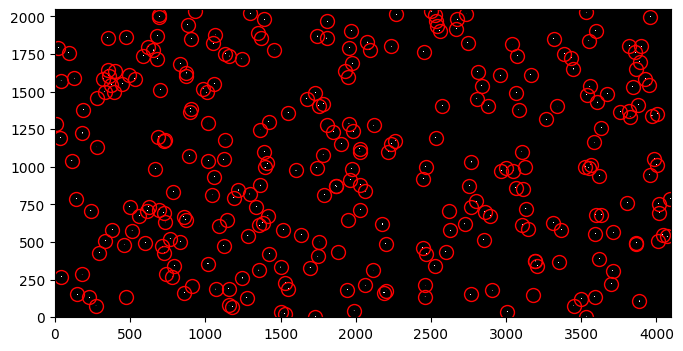

In [12]:
fig, ax = plt.subplots(1, 1, figsize=(9, 4))

ax.imshow(synth_stars_image, vmin=0, vmax=200, interpolation='nearest', 
          cmap='Greys_r', origin='lower')
ax.plot(sources['x_mean'], sources['y_mean'], marker='o', markersize=10, 
        markerfacecolor='none', markeredgecolor='red', linestyle='none')

<a id="option-a"></a>
### Option A: Start with an observed FLC image

In this Option, we add synthetic stars to the scene in an `flc` image and process it appropriately for use with the forward model. We use the `flc` image because it is the closest approximation to a pristine image of the sky. Below we plot a portion of the downloaded 47 Tuc image. Stars of various magnitudes are visible, as well as cosmic rays.

(800.0, 1300.0)

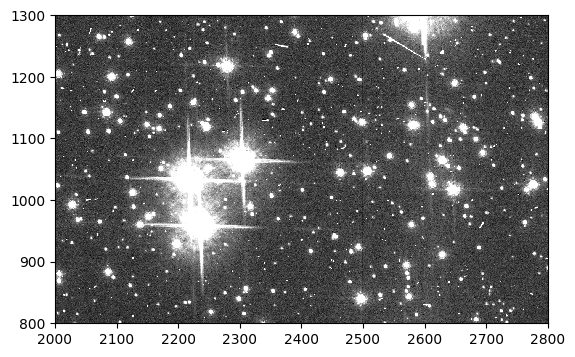

In [13]:
flc = fits.getdata('jd0q14ctq_flc.fits', ext=1)

fig, ax = plt.subplots(1, 1, figsize=(9, 4))

ax.imshow(flc, vmin=0, vmax=200, interpolation='nearest', cmap='Greys_r', origin='lower')

ax.set_xlim(2000, 2800)
ax.set_ylim(800, 1300)

[Top of Page](#title_ID)

<a id="A4"></a>
### 4A. Add artificial stars

Add the image of artificial stars generated above to both CCDs of the `flc` image, and save it as a new file.

In [14]:
hdu = fits.open('jd0q14ctq_flc.fits')

wfc1 = hdu[4].data
wfc2 = hdu[1].data

wfc1 += synth_stars_image
wfc2 += synth_stars_image

hdu.writeto('jd0q14ctq_stars_flc.fits', overwrite=True)

Below we plot a section of the `flc` image with a few artificial stars circled in red.

(800.0, 1300.0)

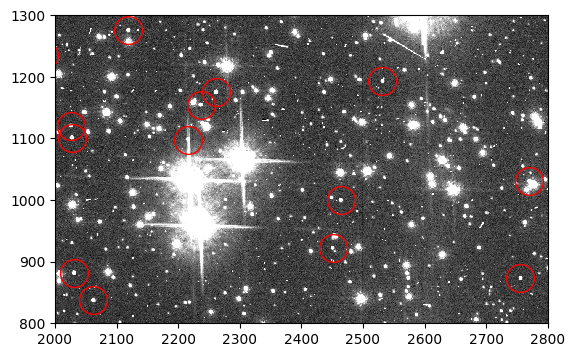

In [15]:
flc_stars = fits.getdata('jd0q14ctq_stars_flc.fits', ext=1)

fig, ax = plt.subplots(1, 1, figsize=(9, 4))

ax.imshow(flc_stars, vmin=0, vmax=200, interpolation='nearest', cmap='Greys_r', 
          origin='lower')
ax.plot(sources['x_mean'], sources['y_mean'], marker='o', markersize=20, 
        markerfacecolor='none', markeredgecolor='red', linestyle='none')

ax.set_xlim(2000, 2800)
ax.set_ylim(800, 1300)

[Top of Page](#title_ID)

<a id="A5"></a>
### 5A. Reverse the flat and dark correction

First, calculate the total exposure time of the 47 Tuc image by combining the exposure time, flash time (if any), and 3 seconds of extra dark time to approximate instrument commanding overheads.

In [16]:
hdu = fits.open('jd0q14ctq_stars_flc.fits')

hdr = hdu[0].header

exptime = hdr['EXPTIME']
flashtime = hdr['FLASHDUR']
darktime = exptime + flashtime + 3

Next, we open the 47 Tuc image and obtain the `SCI` extensions of both CCDs. We multiply by the flat and scale the CTE-corrected dark by the total exposure time. We also run the scaled dark image through a Poisson sampler to include Poisson noise in the dark scene. We then add the dark current to the image. We save the result, which is now effectively a `blc_tmp` file. If the data are post-flashed, we also need to reverse the flash correction. We do this by multiplying the flash file by the flash duration, running it through a Poisson sampler, and adding it to the 47 Tuc image. The lines for this are commented out below. **Note: It is not recommended to use a simulated exposure time that scales pixels in the dark or flash image to or above the full well depth of ~80,000 electrons.**

In [17]:
wfc1 = hdu[4].data
wfc2 = hdu[1].data

wfc1 *= flat_wfc1
wfc2 *= flat_wfc2

wfc1 += np.random.poisson(dkc_wfc1*darktime)
wfc2 += np.random.poisson(dkc_wfc2*darktime)

# wfc1 += np.random.poisson(flash_wfc1*flashtime)
# wfc2 += np.random.poisson(flash_wfc2*flashtime)

hdu.writeto('jd0q14ctq_stars_pfl_dkc.fits', overwrite=True)

 Finally, we update the header keyword `PCTECORR` to `PERFORM`, which is necessary for running the forward model.

In [18]:
fits.setval('jd0q14ctq_stars_pfl_dkc.fits', 'PCTECORR', value='PERFORM')

[Top of Page](#title_ID)

<a id="A6"></a>
### 6A. Run CTE forward model

We are now ready to run the CTE forward model, which simulates the effects of CTE losses while reading out the detector. In this example, we will use the `acstools` module `acscteforwardmodel`. Note that this step may take a few minutes. The resulting filename will be `*_ctefmod.fits`. We rename the file to have the suffix `*_blv_tmp.fits` so that it can be processed by `CALACS` in a later step.

In [19]:
acscteforwardmodel.acscteforwardmodel('jd0q14ctq_stars_pfl_dkc.fits')

git tag: e0988181-dirty
git branch: HEAD
HEAD @: e098818105734475101120a544dfe468207bc690
Setting max threads to 4 out of 4 available
Trying to open jd0q14ctq_stars_pfl_dkc.fits...
Read in Primary header from jd0q14ctq_stars_pfl_dkc.fits...


CALBEG*** ACSCTE -- Version 10.3.5 (08-Feb-2022) ***
Begin    12-Nov-2024 01:58:07 UTC
Input    jd0q14ctq_stars_pfl_dkc.fits
Output   jd0q14ctq_stars_pfl_dkc_ctefmod.fits
Trying to open jd0q14ctq_stars_pfl_dkc.fits...
Read in Primary header from jd0q14ctq_stars_pfl_dkc.fits...
APERTURE WFCENTER
FILTER1 F775W
FILTER2 CLEAR2L
DETECTOR WFC


CCDTAB   jref$72m1821dj_ccd.fits
CCDTAB   PEDIGREE=inflight
CCDTAB   DESCRIP =CCD table with updated readnoise values for CCDGAIN=2.-------------
CCDTAB   DESCRIP =July 2009


PCTECORR PERFORM
PCTEFILE jref$19i16323j_cte.fits
PCTEFILE PEDIGREE=INFLIGHT 01/03/2002 22/07/2010
PCTEFILE DESCRIP =Parameters needed for gen2 pixel-based CTE correction -------------
Trying to open jref$19i16323j_cte.fits...
Read in Prima

(pctecorr) ...complete.
(pctecorr) Total count difference (corrected-raw) incurred from correction: -360764.375000 (-0.051047%)
(pctecorr) Performing CTE correction for amp D
(pctecorr) Read noise level from CCDTAB: 5.050000.
(pctecorr) ...complete.
(pctecorr) Creating charge trap image...
(pctecorr) Time taken to populate pixel trap map image: 0.01(s) with 4 threads
(pctecorr) ...complete.
(pctecorr) Running forward model simulation...


(pctecorr) ...complete.
(pctecorr) Total count difference (corrected-raw) incurred from correction: -415047.250000 (-0.049186%)
(pctecorr) CTE run time for current chip: 119.04(s) with 4 procs/threads

(pctecorr) Using parallel processing provided by OpenMP inside CTE routine
(pctecorr) Performing CTE correction for amp A
(pctecorr) Read noise level from CCDTAB: 4.350000.
(pctecorr) ...complete.
(pctecorr) Creating charge trap image...
(pctecorr) Time taken to populate pixel trap map image: 0.01(s) with 4 threads
(pctecorr) ...complete.
(pctecorr) Running forward model simulation...


(pctecorr) ...complete.
(pctecorr) Total count difference (corrected-raw) incurred from correction: -281948.562500 (-0.048664%)
(pctecorr) Performing CTE correction for amp B
(pctecorr) Read noise level from CCDTAB: 3.750000.
(pctecorr) ...complete.
(pctecorr) Creating charge trap image...
(pctecorr) Time taken to populate pixel trap map image: 0.01(s) with 4 threads
(pctecorr) ...complete.
(pctecorr) Running forward model simulation...


(pctecorr) ...complete.
(pctecorr) Total count difference (corrected-raw) incurred from correction: -454912.468750 (-0.040164%)
(pctecorr) CTE run time for current chip: 132.49(s) with 4 procs/threads

PCTECORR COMPLETE




End      12-Nov-2024 02:02:21 UTC


*** ACSCTE complete ***


In [20]:
os.rename('jd0q14ctq_stars_pfl_dkc_ctefmod.fits', 'jd0q14ctq_stars_ctefmod_blv_tmp.fits')

After the forward model is run, the `SCI` extensions of the image are equivalent to a `blv_tmp` file, in principle. However, the `ERR` extensions are the original `flc` `ERR` extensions plus 10% of the forward model correction. To ensure the `ERR` extensions are accurate for a `blv_tmp` file, we will set every pixel to zero and calculate new values for each pixel according to

$\mathrm{ERR} = \sqrt{\mathrm{SCI} + \mathrm{RN}^2 + (\mathrm{ERR}_{\mathrm{superbias}}g)^2}$,

where $\mathrm{SCI}$ is the pixel value in the `SCI` extension (all negative pixels are set to zero), $\mathrm{RN}$ is the readnoise, $\mathrm{ERR}_{\mathrm{superbias}}$ is the pixel value in the `ERR` extension of the superbias, and $g$ is the gain.

First, we access the header and `SCI` and `ERR` extensions of the forward-modeled data.

In [21]:
hdu = fits.open('jd0q14ctq_stars_ctefmod_blv_tmp.fits')

sci_wfc1 = hdu[4].data
sci_wfc2 = hdu[1].data

err_wfc1 = hdu[5].data
err_wfc2 = hdu[2].data

hdr = hdu[0].header

Next, we take the readnoise and gain values for each quadrant from the header.

In [22]:
rn_A = hdr['READNSEA']
rn_B = hdr['READNSEB']
rn_C = hdr['READNSEC']
rn_D = hdr['READNSED']

gain_A = hdr['ATODGNA']
gain_B = hdr['ATODGNB']
gain_C = hdr['ATODGNC']
gain_D = hdr['ATODGND']

Finally, we make copies of the `SCI` extensions in which to set all negative values to zero. We calculate the appropriate error for each quadrant and save them to the `ERR` extensions of the forward-modeled image.

In [23]:
sci_wfc1_pos = np.copy(sci_wfc1)
sci_wfc2_pos = np.copy(sci_wfc2)

sci_wfc1_pos[sci_wfc1_pos < 0] = 0
sci_wfc2_pos[sci_wfc2_pos < 0] = 0

err_A = np.sqrt(sci_wfc1_pos[:, :2048] + rn_A**2 + (err_bias_wfc1[20:, 24:2072]*gain_A)**2)
err_B = np.sqrt(sci_wfc1_pos[:, 2048:] + rn_B**2 + (err_bias_wfc1[20:, 2072:-24]*gain_B)**2)
err_C = np.sqrt(sci_wfc2_pos[:, :2048] + rn_C**2 + (err_bias_wfc2[:-20, 24:2072]*gain_C)**2)
err_D = np.sqrt(sci_wfc2_pos[:, 2048:] + rn_D**2 + (err_bias_wfc2[:-20, 2072:-24]*gain_D)**2)

err_wfc1[:] = np.hstack((err_A, err_B))
err_wfc2[:] = np.hstack((err_C, err_D))

hdu.writeto('jd0q14ctq_stars_ctefmod_blv_tmp.fits', overwrite=True)

[Top of Page](#title_ID)

<a id="A7"></a>
### (Optional) 7A. Run CTE correction

If desired, we now CTE correct the forward-modeled image. To do this, we need to update the `PCTECORR` keyword to `PERFORM` again and update the `NEXTEND` keyword to 6, the number of extensions left after running the forward model.  (This is because the forward model strips the distortion-related extensions from the input file, but does not update `NEXTEND`.) Finally, run `acscte` on the image. The resulting filename will be `*_blc_tmp.fits`.

In [24]:
fits.setval('jd0q14ctq_stars_ctefmod_blv_tmp.fits', 'PCTECORR', value='PERFORM')
fits.setval('jd0q14ctq_stars_ctefmod_blv_tmp.fits', 'NEXTEND', value=6)

acscte.acscte('jd0q14ctq_stars_ctefmod_blv_tmp.fits')

git tag: e0988181-dirty
git branch: HEAD
HEAD @: e098818105734475101120a544dfe468207bc690
Setting max threads to 4 out of 4 available
Trying to open jd0q14ctq_stars_ctefmod_blv_tmp.fits...
Read in Primary header from jd0q14ctq_stars_ctefmod_blv_tmp.fits...


CALBEG*** ACSCTE -- Version 10.3.5 (08-Feb-2022) ***
Begin    12-Nov-2024 02:02:21 UTC
Input    jd0q14ctq_stars_ctefmod_blv_tmp.fits
Output   jd0q14ctq_stars_ctefmod_blc_tmp.fits
Trying to open jd0q14ctq_stars_ctefmod_blv_tmp.fits...
Read in Primary header from jd0q14ctq_stars_ctefmod_blv_tmp.fits...
APERTURE WFCENTER
FILTER1 F775W
FILTER2 CLEAR2L
DETECTOR WFC


CCDTAB   jref$72m1821dj_ccd.fits
CCDTAB   PEDIGREE=inflight
CCDTAB   DESCRIP =CCD table with updated readnoise values for CCDGAIN=2.-------------
CCDTAB   DESCRIP =July 2009


PCTECORR PERFORM
PCTEFILE jref$19i16323j_cte.fits
PCTEFILE PEDIGREE=INFLIGHT 01/03/2002 22/07/2010
PCTEFILE DESCRIP =Parameters needed for gen2 pixel-based CTE correction -------------
Trying to open 

(pctecorr) Time taken to smooth image: 2.41(s) with 4 threads
(pctecorr) ...complete.
(pctecorr) Creating charge trap image...
(pctecorr) Time taken to populate pixel trap map image: 0.01(s) with 4 threads
(pctecorr) ...complete.
(pctecorr) Running correction algorithm...


(pctecorr) ...complete.
(pctecorr) Total count difference (corrected-raw) incurred from correction: 354650.812500 (0.050212%)
(pctecorr) Performing CTE correction for amp D
(pctecorr) Read noise level from CCDTAB: 5.050000.
(pctecorr) Calculating smooth readnoise image...


(pctecorr) Time taken to smooth image: 2.12(s) with 4 threads
(pctecorr) ...complete.
(pctecorr) Creating charge trap image...
(pctecorr) Time taken to populate pixel trap map image: 0.01(s) with 4 threads
(pctecorr) ...complete.
(pctecorr) Running correction algorithm...


(pctecorr) ...complete.
(pctecorr) Total count difference (corrected-raw) incurred from correction: 407975.250000 (0.048372%)
(pctecorr) CTE run time for current chip: 607.39(s) with 4 procs/threads

(pctecorr) Using parallel processing provided by OpenMP inside CTE routine
(pctecorr) Performing CTE correction for amp A
(pctecorr) Read noise level from CCDTAB: 4.350000.
(pctecorr) Calculating smooth readnoise image...


(pctecorr) Time taken to smooth image: 2.16(s) with 4 threads
(pctecorr) ...complete.
(pctecorr) Creating charge trap image...
(pctecorr) Time taken to populate pixel trap map image: 0.01(s) with 4 threads
(pctecorr) ...complete.
(pctecorr) Running correction algorithm...


(pctecorr) ...complete.
(pctecorr) Total count difference (corrected-raw) incurred from correction: 276167.593750 (0.047693%)
(pctecorr) Performing CTE correction for amp B
(pctecorr) Read noise level from CCDTAB: 3.750000.
(pctecorr) Calculating smooth readnoise image...


(pctecorr) Time taken to smooth image: 2.38(s) with 4 threads
(pctecorr) ...complete.
(pctecorr) Creating charge trap image...
(pctecorr) Time taken to populate pixel trap map image: 0.01(s) with 4 threads
(pctecorr) ...complete.
(pctecorr) Running correction algorithm...


(pctecorr) ...complete.
(pctecorr) Total count difference (corrected-raw) incurred from correction: 458269.687500 (0.040472%)
(pctecorr) CTE run time for current chip: 673.35(s) with 4 procs/threads

PCTECORR COMPLETE




End      12-Nov-2024 02:23:51 UTC


*** ACSCTE complete ***


<a id="A8"></a>
### 8A. Apply flat and dark correction

Finally, we flat-field and dark-correct the forward-modeled image using `acs2d` to produce an `flt`-like image. First, we update the keywords `DARKCORR` and `FLATCORR` to `PERFORM`. All other relevant `CALACS` header keyword switches are set to `COMPLETE` because the original data was an `flc` image. The resulting filename will be `*_flt.fits`. **Note:** If the data were post-flashed, and the flash background was added back in during an earlier step, we must also set `FLSHCORR` equal to `PERFORM`. This option is shown below in a commented out line.

In [25]:
fits.setval('jd0q14ctq_stars_ctefmod_blv_tmp.fits', 'DARKCORR', value='PERFORM')
fits.setval('jd0q14ctq_stars_ctefmod_blv_tmp.fits', 'FLATCORR', value='PERFORM')
# fits.setval('jd0q14ctq_stars_ctefmod_blv_tmp.fits', 'FLSHCORR', value='PERFORM')

acs2d.acs2d('jd0q14ctq_stars_ctefmod_blv_tmp.fits')

git tag: e0988181-dirty
git branch: HEAD
HEAD @: e098818105734475101120a544dfe468207bc690
Trying to open jd0q14ctq_stars_ctefmod_blv_tmp.fits...
Read in Primary header from jd0q14ctq_stars_ctefmod_blv_tmp.fits...


CALBEG*** ACS2D -- Version 10.3.5 (08-Feb-2022) ***
Begin    12-Nov-2024 02:23:51 UTC
Input    jd0q14ctq_stars_ctefmod_blv_tmp.fits
Output   jd0q14ctq_stars_ctefmod_flt.fits
Trying to open jd0q14ctq_stars_ctefmod_blv_tmp.fits...
Read in Primary header from jd0q14ctq_stars_ctefmod_blv_tmp.fits...
APERTURE WFCENTER
FILTER1 F775W
FILTER2 CLEAR2L
DETECTOR WFC


Imset 1  Begin 02:23:51 UTC


CCDTAB   jref$72m1821dj_ccd.fits
CCDTAB   PEDIGREE=inflight
CCDTAB   DESCRIP =CCD table with updated readnoise values for CCDGAIN=2.-------------
CCDTAB   DESCRIP =July 2009


DQICORR  OMIT


DARKCORR PERFORM
DARKFILE jref$78f18443j_drk.fits
DARKFILE PEDIGREE=INFLIGHT 12/02/2016 09/03/2016
DARKFILE DESCRIP =Standard full-frame dark for data taken after Feb 11 2016 08:10:42-
Darktime from head

FLATCORR COMPLETE


SHADCORR OMIT


PHOTCORR OMIT
Imset 1  End 02:23:52 UTC


Imset 2  Begin 02:23:52 UTC


CCDTAB   jref$72m1821dj_ccd.fits
CCDTAB   PEDIGREE=inflight
CCDTAB   DESCRIP =CCD table with updated readnoise values for CCDGAIN=2.-------------
CCDTAB   DESCRIP =July 2009


DQICORR  OMIT


DARKCORR PERFORM
Darktime from header 342.239197


Mean of dark image (MEANDARK) = 4.16998
DARKCORR COMPLETE


FLSHCORR OMIT


FLATCORR PERFORM
FLATCORR COMPLETE


SHADCORR OMIT


PHOTCORR OMIT


Imset 2  End 02:23:52 UTC


End      12-Nov-2024 02:23:52 UTC


*** ACS2D complete ***


If the forward-modeled image was CTE-corrected in [Step 7A](#A7), we run `acs2d` on the CTE-corrected image. The resulting filename will be `*_flc.fits`.

In [26]:
fits.setval('jd0q14ctq_stars_ctefmod_blc_tmp.fits', 'DARKCORR', value='PERFORM')
fits.setval('jd0q14ctq_stars_ctefmod_blc_tmp.fits', 'FLATCORR', value='PERFORM')
# fits.setval('jd0q14ctq_stars_ctefmod_blv_tmp.fits', 'FLSHCORR', value='PERFORM')

acs2d.acs2d('jd0q14ctq_stars_ctefmod_blc_tmp.fits')

git tag: e0988181-dirty
git branch: HEAD
HEAD @: e098818105734475101120a544dfe468207bc690
Trying to open jd0q14ctq_stars_ctefmod_blc_tmp.fits...
Read in Primary header from jd0q14ctq_stars_ctefmod_blc_tmp.fits...


CALBEG*** ACS2D -- Version 10.3.5 (08-Feb-2022) ***
Begin    12-Nov-2024 02:23:52 UTC
Input    jd0q14ctq_stars_ctefmod_blc_tmp.fits
Output   jd0q14ctq_stars_ctefmod_flc.fits
Trying to open jd0q14ctq_stars_ctefmod_blc_tmp.fits...
Read in Primary header from jd0q14ctq_stars_ctefmod_blc_tmp.fits...
APERTURE WFCENTER
FILTER1 F775W
FILTER2 CLEAR2L
DETECTOR WFC


Imset 1  Begin 02:23:52 UTC


CCDTAB   jref$72m1821dj_ccd.fits
CCDTAB   PEDIGREE=inflight
CCDTAB   DESCRIP =CCD table with updated readnoise values for CCDGAIN=2.-------------
CCDTAB   DESCRIP =July 2009


DQICORR  OMIT


DARKCORR PERFORM
DARKFILE jref$78g0300bj_dkc.fits
DARKFILE PEDIGREE=INFLIGHT 12/02/2016 09/03/2016
DARKFILE DESCRIP =CTE corrected dark for WFC data taken after Feb 11 2016 08:10:42---
Darktime from head

FLATCORR COMPLETE


SHADCORR OMIT


PHOTCORR OMIT
Imset 1  End 02:23:52 UTC


Imset 2  Begin 02:23:52 UTC


CCDTAB   jref$72m1821dj_ccd.fits
CCDTAB   PEDIGREE=inflight
CCDTAB   DESCRIP =CCD table with updated readnoise values for CCDGAIN=2.-------------
CCDTAB   DESCRIP =July 2009


DQICORR  OMIT


DARKCORR PERFORM
Darktime from header 342.239197


Mean of dark image (MEANDARK) = 3.4793
DARKCORR COMPLETE


FLSHCORR OMIT


FLATCORR PERFORM
FLATCORR COMPLETE


SHADCORR OMIT


PHOTCORR OMIT


Imset 2  End 02:23:53 UTC


End      12-Nov-2024 02:23:53 UTC


*** ACS2D complete ***


The 47 Tuc image(s) are now prepared for further analysis appropriate for the user's science. The cells below plot a portion of the final images, the `flt` and, if produced, the `flc`.

(800.0, 1300.0)

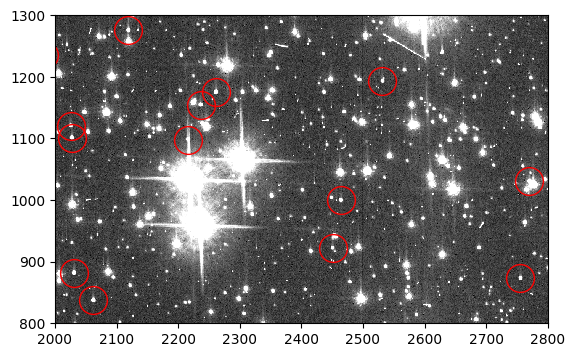

In [27]:
flt_stars = fits.getdata('jd0q14ctq_stars_ctefmod_flt.fits', ext=1)

fig, ax = plt.subplots(1, 1, figsize=(9, 4))

ax.imshow(flt_stars, vmin=0, vmax=200, interpolation='nearest', cmap='Greys_r', 
          origin='lower')
ax.plot(sources['x_mean'], sources['y_mean'], marker='o', markersize=20, 
        markerfacecolor='none', markeredgecolor='red', linestyle='none')

ax.set_xlim(2000, 2800)
ax.set_ylim(800, 1300)

(800.0, 1300.0)

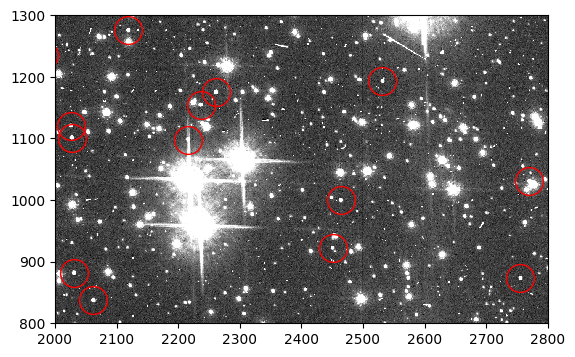

In [28]:
flc_stars = fits.getdata('jd0q14ctq_stars_ctefmod_flc.fits', ext=1)

fig, ax = plt.subplots(1, 1, figsize=(9, 4))

ax.imshow(flc_stars, vmin=0, vmax=200, interpolation='nearest', cmap='Greys_r', 
          origin='lower')
ax.plot(sources['x_mean'], sources['y_mean'], marker='o', markersize=20, 
        markerfacecolor='none', markeredgecolor='red', linestyle='none')

ax.set_xlim(2000, 2800)
ax.set_ylim(800, 1300)

[Top of Page](#title_ID)

<a id="option-b"></a>
### Option B: Start with a synthetic image

In this Option, we start with the `raw` file from the `jd0q14ctq` dataset and process the `SCI` extensions to make a completely synthetic dataset. We then process it appropriately for use in the forward model.

<a id="B4"></a>
### 4B. Create a synthetic image

We will create an image that is equivalent to a `blc_tmp` file. This means that the image is not flat-fielded and includes sky background, Poisson noise from the sky, artificial stars or other sources, Poisson noise from the sources, dark current, and dark noise.

We first process the data with `acsccd` within `acstools` to create a `blv_tmp`. This ensures that the error (`ERR`) and data quality (`DQ`) extensions are created and the header keywords for every extension are initially populated, which is necessary for the CTE forward model to run.

In [29]:
acsccd.acsccd('jd0q14ctq_raw.fits')

git tag: e0988181-dirty
git branch: HEAD
HEAD @: e098818105734475101120a544dfe468207bc690
Trying to open jd0q14ctq_raw.fits...
Read in Primary header from jd0q14ctq_raw.fits...


CALBEG*** ACSCCD -- Version 10.3.5 (08-Feb-2022) ***
Begin    12-Nov-2024 02:23:53 UTC
Input    jd0q14ctq_raw.fits
Output   jd0q14ctq_blv_tmp.fits
Trying to open jd0q14ctq_raw.fits...
Read in Primary header from jd0q14ctq_raw.fits...
APERTURE WFCENTER
FILTER1 F775W
FILTER2 CLEAR2L
DETECTOR WFC


CCDTAB   jref$72m1821dj_ccd.fits
CCDTAB   PEDIGREE=inflight
CCDTAB   DESCRIP =CCD table with updated readnoise values for CCDGAIN=2.-------------
CCDTAB   DESCRIP =July 2009


DQICORR  PERFORM
DQITAB   jref$25g1256nj_bpx.fits
DQITAB   PEDIGREE=INFLIGHT 30/03/2002 30/05/2002
DQITAB   DESCRIP =FITS reference table for bad pixel locations on ACS WFC
DQICORR  COMPLETE


BIASCORR PERFORM
BIASFILE jref$66418280j_bia.fits
BIASFILE PEDIGREE=INFLIGHT 12/02/2016 09/03/2016
BIASFILE DESCRIP =Standard full-frame bias for data take

Bias shift correcting for bias level in Amp B of 4025.7480 electrons.
Bias shift correcting for bias level in Amp B of 4025.7480 electrons.
Bias shift correcting for bias level in Amp C of 4437.9683 electrons.
Bias shift correcting for bias level in Amp C of 4437.9683 electrons.
Bias shift correcting for bias level in Amp D of 4624.3633 electrons.
Performing stripe removal and bias level subtraction for full frame data.
Bias shift correcting for bias level in Amp D of 4624.3633 electrons.
Bias shift correcting for bias level in Amp D of 4624.3633 electrons.
Bias shift correcting for bias level in Amp D of 4624.3633 electrons.
Bias shift correcting for bias level in Amp D of 4624.3633 electrons.
     bias level of 0.561443 electrons was subtracted for AMP A.
     bias level of -0.0598474 electrons was subtracted for AMP B.
     bias level of -0.32127 electrons was subtracted for AMP C.
     bias level of 0.5666 electrons was subtracted for AMP D.


BLEVCORR COMPLETE
Full Frame adjusted Darktime: 342.239197

DARKTIME from SCI header: 342.239197  Offset from CCDTAB: 0.000000  Final DARKTIME: 342.239197

Full-well saturation flagging being performed for imset 1.

Full-frame full-well saturation image flagging step being performed.

Full-frame full-well saturation image flagging step done.


Full-well saturation flagging being performed for imset 2.

Full-frame full-well saturation image flagging step being performed.

Full-frame full-well saturation image flagging step done.


    Uncertainty array initialized,
    readnoise =4.35,3.75,4.05,5.05
    gain =2.02,1.886,2.017,2.011
   default bias levels =4242,4060.6,4481.8,4645.4


SINKCORR PERFORM
SNKCFILE jref$25e1534hj_snk.fits
SNKCFILE PEDIGREE=INFLIGHT 12/02/2016 09/03/2016
SNKCFILE DESCRIP =Sink pixel reference file ----------------------------
SINKCORR COMPLETE




End      12-Nov-2024 02:23:54 UTC


*** ACSCCD complete ***


Next, we obtain the `SCI` extensions from the `blv_tmp` file, and set the pixels to zero.

In [30]:
hdu = fits.open('jd0q14ctq_blv_tmp.fits')
    
wfc1 = hdu[4].data
wfc2 = hdu[1].data

wfc1[:] = np.zeros(shape)
wfc2[:] = np.zeros(shape)

We then generate an image containing a user-selected sky background level (here we choose 40 electrons arbitrarily) and Poisson noise. Finally, we sum the noise image and the artificial star image, and save the result as a new file.

In [31]:
noise_image = make_noise_image(shape, distribution='poisson', mean=40, seed=12345)

wfc1 += noise_image + synth_stars_image
wfc2 += noise_image + synth_stars_image

hdu.writeto('synth.fits', overwrite=True)

Below we plot a portion of the synthetic image, with sources circled in red.

(800.0, 1300.0)

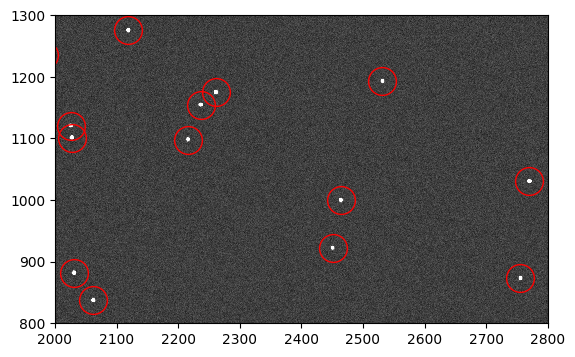

In [32]:
synth = fits.getdata('synth.fits', ext=1)

fig, ax = plt.subplots(1, 1, figsize=(9, 4))

ax.imshow(synth, vmin=0, vmax=200, interpolation='nearest', cmap='Greys_r', 
          origin='lower')
ax.plot(sources['x_mean'], sources['y_mean'], marker='o', markersize=20, 
        markerfacecolor='none', markeredgecolor='red', linestyle='none')

ax.set_xlim(2000, 2800)
ax.set_ylim(800, 1300)

In order to properly remove the dark current after the forward model is run, we update the exposure time and flash duration header keywords, `EXPTIME` and `FLASHDUR`, with the desired simulated exposure time. The total exposure time used for the dark correction is the combination of exposure time, flash duration, and overhead (which depends on whether the data are post-flashed or not). Here we set `EXPTIME` to 300 seconds and `FLASHDUR` to 0 seconds. In principle one should retrieve the overheads from CCDTAB, but we provide a simpler approach here. Please note that the overhead times may change.

In [33]:
exptime = 300.
flashdur = 0.

hdu = fits.open('synth.fits')

hdr = hdu[0].header

hdr['EXPTIME'] = exptime
hdr['FLASHDUR'] = flashdur

if flashdur > 0:
    overhead = 2.43
else:
    overhead = 0.21

darktime = exptime + flashdur + overhead

We need to update the FITS header with the correct dark time for use in a later step. **However, we leave off the overhead, because ACSCCD (run in a later step) will automatically append the overhead to the dark time in the header.** We still use the darktime variable with overhead to manually add the dark current to our model below.

In [34]:
hdr['DARKTIME'] = darktime - overhead

Next, obtain the `SCI` extensions of both CCDs. We then multiply by the flat and scale the CTE-corrected dark by a chosen exposure time. We also run the scaled dark image through a Poisson sampler to include Poisson noise in the dark scene. We then add the dark current to the image. If post-flash is desired, multiply the flash reference file by the flash duration, run it through a Poisson sampler, and add to the synthetic data. This is shown in the commented out lines below. We save the result, which is now effectively a `blc_tmp` file. **Note: It is not recommended to use a simulated exposure time that scales pixels in the dark or flash image to or above the full well depth of ~80,000 electrons.**

Note that these reference files are specific to the anneal cycle in which these data were taken. If an observation date other than that listed in the `DATE-OBS` header keyword is desired for the synthetic data, different reference files will be needed. These can be found by updating the `DATE-OBS` header keyword in the synthetic image to the desired observation date, and rerunning the cell in [Step 2](#download) which uses `CRDS bestrefs` to download the correct reference files.

In [35]:
wfc1 = hdu[4].data
wfc2 = hdu[1].data

wfc1 *= flat_wfc1
wfc2 *= flat_wfc2

wfc1 += np.random.poisson(dkc_wfc1*darktime)
wfc2 += np.random.poisson(dkc_wfc2*darktime)

# wfc1 += np.random.poisson(flash_wfc1*flashdur)
# wfc2 += np.random.poisson(flash_wfc2*flashdur)

hdu.writeto('synth_blc_tmp.fits', overwrite=True)

[Top of Page](#title_ID)

<a id="B5"></a>
### 5B. Run CTE forward model

We are now ready to run the CTE forward model, which simulates the effects of CTE losses while reading out the detector. In this example, we will use the `acstools` module `acscteforwardmodel`. Note that this step may take a few minutes. The resulting filename will be `*_ctefmod.fits`. We rename this to `*_blv_tmp.fits` in order to ensure the correct behavior from `acs2d` in a later step.

In [36]:
acscteforwardmodel.acscteforwardmodel('synth_blc_tmp.fits')

os.rename('synth_blc_tmp_ctefmod.fits', 'synth_ctefmod_blv_tmp.fits')

git tag: e0988181-dirty
git branch: HEAD
HEAD @: e098818105734475101120a544dfe468207bc690
Setting max threads to 4 out of 4 available
Trying to open synth_blc_tmp.fits...
Read in Primary header from synth_blc_tmp.fits...


CALBEG*** ACSCTE -- Version 10.3.5 (08-Feb-2022) ***
Begin    12-Nov-2024 02:23:56 UTC
Input    synth_blc_tmp.fits
Output   synth_blc_tmp_ctefmod.fits
Trying to open synth_blc_tmp.fits...
Read in Primary header from synth_blc_tmp.fits...
APERTURE WFCENTER
FILTER1 F775W
FILTER2 CLEAR2L
DETECTOR WFC


CCDTAB   jref$72m1821dj_ccd.fits
CCDTAB   PEDIGREE=inflight
CCDTAB   DESCRIP =CCD table with updated readnoise values for CCDGAIN=2.-------------
CCDTAB   DESCRIP =July 2009


PCTECORR PERFORM
PCTEFILE jref$19i16323j_cte.fits
PCTEFILE PEDIGREE=INFLIGHT 01/03/2002 22/07/2010
PCTEFILE DESCRIP =Parameters needed for gen2 pixel-based CTE correction -------------
Trying to open jref$19i16323j_cte.fits...
Read in Primary header from jref$19i16323j_cte.fits...
(pctecorr) Generat

(pctecorr) ...complete.
(pctecorr) Total count difference (corrected-raw) incurred from correction: -300354.250000 (-0.135758%)
(pctecorr) Performing CTE correction for amp D
(pctecorr) Read noise level from CCDTAB: 5.050000.
(pctecorr) ...complete.
(pctecorr) Creating charge trap image...
(pctecorr) Time taken to populate pixel trap map image: 0.01(s) with 4 threads
(pctecorr) ...complete.
(pctecorr) Running forward model simulation...


(pctecorr) ...complete.
(pctecorr) Total count difference (corrected-raw) incurred from correction: -312386.093750 (-0.134337%)
(pctecorr) CTE run time for current chip: 51.69(s) with 4 procs/threads

(pctecorr) Using parallel processing provided by OpenMP inside CTE routine
(pctecorr) Performing CTE correction for amp A
(pctecorr) Read noise level from CCDTAB: 4.350000.
(pctecorr) ...complete.
(pctecorr) Creating charge trap image...
(pctecorr) Time taken to populate pixel trap map image: 0.01(s) with 4 threads
(pctecorr) ...complete.
(pctecorr) Running forward model simulation...


(pctecorr) ...complete.
(pctecorr) Total count difference (corrected-raw) incurred from correction: -301598.562500 (-0.142812%)
(pctecorr) Performing CTE correction for amp B
(pctecorr) Read noise level from CCDTAB: 3.750000.
(pctecorr) ...complete.
(pctecorr) Creating charge trap image...
(pctecorr) Time taken to populate pixel trap map image: 0.01(s) with 4 threads
(pctecorr) ...complete.
(pctecorr) Running forward model simulation...


(pctecorr) ...complete.
(pctecorr) Total count difference (corrected-raw) incurred from correction: -311740.656250 (-0.137931%)
(pctecorr) CTE run time for current chip: 51.50(s) with 4 procs/threads

PCTECORR COMPLETE




End      12-Nov-2024 02:25:41 UTC


*** ACSCTE complete ***


At this point, we also add readnoise to the forward-modeled `SCI` extensions to complete the readout simulation. We find the readnoise values for each quadrant of the image from the header keywords `READNSEA`, `READNSEB`, etc. We make a noise image for each quadrant, concatenate quadrants A and B and quadrants C and D, and add them to the synthetic image.

In [37]:
rn_A = hdr['READNSEA']
rn_B = hdr['READNSEB']
rn_C = hdr['READNSEC']
rn_D = hdr['READNSED']

img_rn_A = make_noise_image((shape[0], int(shape[1]/2)), distribution='gaussian', 
                            mean=0., stddev=rn_A)
img_rn_B = make_noise_image((shape[0], int(shape[1]/2)), distribution='gaussian', 
                            mean=0., stddev=rn_B)
img_rn_C = make_noise_image((shape[0], int(shape[1]/2)), distribution='gaussian', 
                            mean=0., stddev=rn_C)
img_rn_D = make_noise_image((shape[0], int(shape[1]/2)), distribution='gaussian', 
                            mean=0., stddev=rn_D)

wfc1_rn = np.hstack((img_rn_A, img_rn_B))
wfc2_rn = np.hstack((img_rn_C, img_rn_D))

In [38]:
hdu = fits.open('synth_ctefmod_blv_tmp.fits')

wfc1 = hdu[4].data
wfc2 = hdu[1].data

wfc1 += wfc1_rn
wfc2 += wfc2_rn

hdu.writeto('synth_ctefmod_rn_blv_tmp.fits', overwrite=True)

The `SCI` extensions of this image are now equivalent to a `blv_tmp` file, in principle. However, the `ERR` extensions are the original `blv_tmp` `ERR` extensions plus 10% of the forward model correction. To ensure the `ERR` extensions are accurate, we will calculate new values for each pixel according to

$\mathrm{ERR} = \sqrt{\mathrm{SCI} + \mathrm{RN}^2 + (\mathrm{ERR}_{\mathrm{superbias}}g)^2}$,

where $\mathrm{SCI}$ is the pixel value in the `SCI` extension (all negative pixels are set to zero), $\mathrm{RN}$ is the readnoise, $\mathrm{ERR}_{\mathrm{superbias}}$ is the pixel value in the `ERR` extension of the superbias, and $g$ is the gain.

First, we access the header and `SCI` and `ERR` extensions of the forward-modeled data.

In [39]:
hdu = fits.open('synth_ctefmod_rn_blv_tmp.fits')

sci_wfc1 = hdu[4].data
sci_wfc2 = hdu[1].data

err_wfc1 = hdu[5].data
err_wfc2 = hdu[2].data

hdr = hdu[0].header

Next, we take the readnoise and gain values for each quadrant from the header.

In [40]:
rn_A = hdr['READNSEA']
rn_B = hdr['READNSEB']
rn_C = hdr['READNSEC']
rn_D = hdr['READNSED']

gain_A = hdr['ATODGNA']
gain_B = hdr['ATODGNB']
gain_C = hdr['ATODGNC']
gain_D = hdr['ATODGND']

Finally, we make copies of the `SCI` extensions in which to set all negative values to zero. We calculate the appropriate error for each quadrant and save them to the `ERR` extensions of the forward-modeled image.

In [41]:
sci_wfc1_pos = np.copy(sci_wfc1)
sci_wfc2_pos = np.copy(sci_wfc2)

sci_wfc1_pos[sci_wfc1_pos < 0] = 0
sci_wfc2_pos[sci_wfc2_pos < 0] = 0

# The superbias ERR arrays contain 20 rows of virtual overscan at the edge of 
# each CCD furthest from the amplifier and 24 columns of physical prescan on the
# left and right edges.
err_A = np.sqrt(sci_wfc1_pos[:, :2048] + rn_A**2 + (err_bias_wfc1[20:, 24:2072]*gain_A)**2)
err_B = np.sqrt(sci_wfc1_pos[:, 2048:] + rn_B**2 + (err_bias_wfc1[20:, 2072:-24]*gain_B)**2)
err_C = np.sqrt(sci_wfc2_pos[:, :2048] + rn_C**2 + (err_bias_wfc2[:-20, 24:2072]*gain_C)**2)
err_D = np.sqrt(sci_wfc2_pos[:, 2048:] + rn_D**2 + (err_bias_wfc2[:-20, 2072:-24]*gain_D)**2)

err_wfc1[:] = np.hstack((err_A, err_B))
err_wfc2[:] = np.hstack((err_C, err_D))

hdu.writeto('synth_ctefmod_rn_blv_tmp.fits', overwrite=True)

We also repopulate the DQ extensions because they reflect the processing of the original `blv_tmp` `SCI` extensions. To do this, we reprocess the data with `DQICORR` and `SINKCORR`, both within `acsccd`, and add in the DQ extensions of the appropriate superbias file. First, we rename the synthetic image to have a filename `*_raw.fits`, or `acsccd` will fail. Then, we update the `DQICORR` and `SINKCORR` header keywords to `PERFORM` and run `acsccd`. The output will be `*_blv_tmp.fits` again.

This step will also add the proper overhead to `DARKTIME` header keyword, but only if using CALACS v10.3.3 or later. We first check the version.

In [42]:
os.system('calacs.e --version')

10.3.5 (08-Feb-2022)


0

If your version of CALCACS is prior to v10.3.3, please update. Now let's run ACSCCD.

In [43]:
os.rename('synth_ctefmod_rn_blv_tmp.fits', 'synth_ctefmod_rn_raw.fits')

fits.setval('synth_ctefmod_rn_raw.fits', 'DQICORR', value='PERFORM')
fits.setval('synth_ctefmod_rn_raw.fits', 'SINKCORR', value='PERFORM')

acsccd.acsccd('synth_ctefmod_rn_raw.fits')

git tag: e0988181-dirty
git branch: HEAD
HEAD @: e098818105734475101120a544dfe468207bc690
Trying to open synth_ctefmod_rn_raw.fits...
Read in Primary header from synth_ctefmod_rn_raw.fits...


CALBEG*** ACSCCD -- Version 10.3.5 (08-Feb-2022) ***
Begin    12-Nov-2024 02:25:42 UTC
Input    synth_ctefmod_rn_raw.fits
Output   synth_ctefmod_rn_blv_tmp.fits
Trying to open synth_ctefmod_rn_raw.fits...
Read in Primary header from synth_ctefmod_rn_raw.fits...
APERTURE WFCENTER
FILTER1 F775W
FILTER2 CLEAR2L
DETECTOR WFC


CCDTAB   jref$72m1821dj_ccd.fits
CCDTAB   PEDIGREE=inflight
CCDTAB   DESCRIP =CCD table with updated readnoise values for CCDGAIN=2.-------------
CCDTAB   DESCRIP =July 2009
Warning    Could not find appropriate row from OSCNTAB. 
Warning    Could not find appropriate row from OSCNTAB. 


DQICORR  PERFORM
DQITAB   jref$25g1256nj_bpx.fits
DQITAB   PEDIGREE=INFLIGHT 30/03/2002 30/05/2002
DQITAB   DESCRIP =FITS reference table for bad pixel locations on ACS WFC
DQICORR  COMPLETE



SINKCORR COMPLETE




End      12-Nov-2024 02:25:42 UTC


*** ACSCCD complete ***


Next, obtain the DQ extensions of the superbias file, and add them to the new DQ extensions of the synthetic data with a `bitwise_or` operator. 

In [44]:
hdu = fits.open('synth_ctefmod_rn_blv_tmp.fits')

dq_wfc1 = hdu[6].data
dq_wfc2 = hdu[3].data

dq_wfc1[:] = np.bitwise_or(dq_wfc1, dq_bias_wfc1[20:, 24:-24])
dq_wfc2[:] = np.bitwise_or(dq_wfc2, dq_bias_wfc2[:-20, 24:-24])

Also, acsccd assumes the input image is in DN and converts it to counts by multiplying by the gain. We defined our model in electrons though, so the acsccd conversion to electrons was unnecessary. We divide by the gains to fix this and replace the image.

In [45]:
sci_wfc1 = hdu[4].data
sci_wfc2 = hdu[1].data

sci_wfc1[:, :2048] /= gain_A
sci_wfc1[:, 2048:] /= gain_B
sci_wfc2[:, :2048] /= gain_C
sci_wfc2[:, 2048:] /= gain_D

err_wfc1 = hdu[5].data
err_wfc2 = hdu[2].data

err_wfc1[:, :2048] /= gain_A
err_wfc1[:, 2048:] /= gain_B
err_wfc2[:, :2048] /= gain_C
err_wfc2[:, 2048:] /= gain_D

hdu.writeto('synth_ctefmod_rn_blv_tmp.fits', overwrite=True)

[Top of Page](#title_ID)

<a id="B6"></a>
### 6B. (Optional) Run CTE correction

If desired, we now CTE correct the forward-modeled image. To do this, we need to update the `PCTECORR` keyword to `PERFORM` again, and run `acscte` on the image. The resulting filename will be `*_blc_tmp.fits`.

In [46]:
fits.setval('synth_ctefmod_rn_blv_tmp.fits', 'PCTECORR', value='PERFORM')

acscte.acscte('synth_ctefmod_rn_blv_tmp.fits')

git tag: e0988181-dirty
git branch: HEAD
HEAD @: e098818105734475101120a544dfe468207bc690
Setting max threads to 4 out of 4 available
Trying to open synth_ctefmod_rn_blv_tmp.fits...
Read in Primary header from synth_ctefmod_rn_blv_tmp.fits...


CALBEG*** ACSCTE -- Version 10.3.5 (08-Feb-2022) ***
Begin    12-Nov-2024 02:25:42 UTC
Input    synth_ctefmod_rn_blv_tmp.fits
Output   synth_ctefmod_rn_blc_tmp.fits
Trying to open synth_ctefmod_rn_blv_tmp.fits...
Read in Primary header from synth_ctefmod_rn_blv_tmp.fits...
APERTURE WFCENTER
FILTER1 F775W
FILTER2 CLEAR2L
DETECTOR WFC


CCDTAB   jref$72m1821dj_ccd.fits
CCDTAB   PEDIGREE=inflight
CCDTAB   DESCRIP =CCD table with updated readnoise values for CCDGAIN=2.-------------
CCDTAB   DESCRIP =July 2009


PCTECORR PERFORM
PCTEFILE jref$19i16323j_cte.fits
PCTEFILE PEDIGREE=INFLIGHT 01/03/2002 22/07/2010
PCTEFILE DESCRIP =Parameters needed for gen2 pixel-based CTE correction -------------
Trying to open jref$19i16323j_cte.fits...
Read in Primary

(pctecorr) Time taken to smooth image: 1.80(s) with 4 threads
(pctecorr) ...complete.
(pctecorr) Creating charge trap image...
(pctecorr) Time taken to populate pixel trap map image: 0.01(s) with 4 threads
(pctecorr) ...complete.
(pctecorr) Running correction algorithm...


(pctecorr) ...complete.
(pctecorr) Total count difference (corrected-raw) incurred from correction: 294299.812500 (0.133202%)
(pctecorr) Performing CTE correction for amp D
(pctecorr) Read noise level from CCDTAB: 5.050000.
(pctecorr) Calculating smooth readnoise image...


(pctecorr) Time taken to smooth image: 1.65(s) with 4 threads
(pctecorr) ...complete.
(pctecorr) Creating charge trap image...
(pctecorr) Time taken to populate pixel trap map image: 0.01(s) with 4 threads
(pctecorr) ...complete.
(pctecorr) Running correction algorithm...


(pctecorr) ...complete.
(pctecorr) Total count difference (corrected-raw) incurred from correction: 305505.250000 (0.131552%)
(pctecorr) CTE run time for current chip: 257.21(s) with 4 procs/threads

(pctecorr) Using parallel processing provided by OpenMP inside CTE routine
(pctecorr) Performing CTE correction for amp A
(pctecorr) Read noise level from CCDTAB: 4.350000.
(pctecorr) Calculating smooth readnoise image...


(pctecorr) Time taken to smooth image: 1.69(s) with 4 threads
(pctecorr) ...complete.
(pctecorr) Creating charge trap image...
(pctecorr) Time taken to populate pixel trap map image: 0.01(s) with 4 threads
(pctecorr) ...complete.
(pctecorr) Running correction algorithm...


(pctecorr) ...complete.
(pctecorr) Total count difference (corrected-raw) incurred from correction: 294856.562500 (0.139819%)
(pctecorr) Performing CTE correction for amp B
(pctecorr) Read noise level from CCDTAB: 3.750000.
(pctecorr) Calculating smooth readnoise image...


(pctecorr) Time taken to smooth image: 1.75(s) with 4 threads
(pctecorr) ...complete.
(pctecorr) Creating charge trap image...
(pctecorr) Time taken to populate pixel trap map image: 0.01(s) with 4 threads
(pctecorr) ...complete.
(pctecorr) Running correction algorithm...


(pctecorr) ...complete.
(pctecorr) Total count difference (corrected-raw) incurred from correction: 305870.250000 (0.135526%)
(pctecorr) CTE run time for current chip: 256.43(s) with 4 procs/threads

PCTECORR COMPLETE




End      12-Nov-2024 02:34:20 UTC


*** ACSCTE complete ***


<a id="B7"></a>
### 7B. Apply flat and dark correction

Finally, we flat-field and dark-correct the forward-modeled image using `acs2d` to produce an `flt`-like image. We first ensure that the `DARKCORR`, `FLATCORR`, and if necessary, `FLSHCORR` header keywords are set to `PERFORM`. The resulting filename will be `*_flt.fits`.

In [47]:
fits.setval('synth_ctefmod_rn_blv_tmp.fits', 'DARKCORR', value='PERFORM')
fits.setval('synth_ctefmod_rn_blv_tmp.fits', 'FLATCORR', value='PERFORM')
# fits.setval('synth_ctefmod_rn_blv_tmp.fits', 'FLSHCORR', value='PERFORM')

acs2d.acs2d('synth_ctefmod_rn_blv_tmp.fits')

git tag: e0988181-dirty
git branch: HEAD
HEAD @: e098818105734475101120a544dfe468207bc690
Trying to open synth_ctefmod_rn_blv_tmp.fits...
Read in Primary header from synth_ctefmod_rn_blv_tmp.fits...


CALBEG*** ACS2D -- Version 10.3.5 (08-Feb-2022) ***
Begin    12-Nov-2024 02:34:20 UTC
Input    synth_ctefmod_rn_blv_tmp.fits
Output   synth_ctefmod_rn_flt.fits
Trying to open synth_ctefmod_rn_blv_tmp.fits...
Read in Primary header from synth_ctefmod_rn_blv_tmp.fits...
APERTURE WFCENTER
FILTER1 F775W
FILTER2 CLEAR2L
DETECTOR WFC


Imset 1  Begin 02:34:20 UTC


CCDTAB   jref$72m1821dj_ccd.fits
CCDTAB   PEDIGREE=inflight
CCDTAB   DESCRIP =CCD table with updated readnoise values for CCDGAIN=2.-------------
CCDTAB   DESCRIP =July 2009


DQICORR  OMIT


DARKCORR PERFORM
DARKFILE jref$78f18443j_drk.fits
DARKFILE PEDIGREE=INFLIGHT 12/02/2016 09/03/2016
DARKFILE DESCRIP =Standard full-frame dark for data taken after Feb 11 2016 08:10:42-
Darktime from header 300.000000
Mean of dark image (MEANDARK

FLATCORR COMPLETE


SHADCORR OMIT


PHOTCORR PERFORM
Found parameterized variable 1.
NUMPAR=1, N=1
Allocated 1 parnames
Adding parameter mjd#57451.3694 as parnames[0]
==> Value of PHOTFLAM = 1.0033185e-19
==> Value of PHOTPLAM = 7693.4699
==> Value of PHOTBW = 434.53752
IMPHTTAB jref$4af1559ij_imp.fits
IMPHTTAB PEDIGREE=INFLIGHT 18/04/2000 29/09/2020
IMPHTTAB DESCRIP =photometry keywords reference file---------------------------------
PHOTCORR COMPLETE
Imset 1  End 02:34:21 UTC


Imset 2  Begin 02:34:21 UTC


CCDTAB   jref$72m1821dj_ccd.fits
CCDTAB   PEDIGREE=inflight
CCDTAB   DESCRIP =CCD table with updated readnoise values for CCDGAIN=2.-------------
CCDTAB   DESCRIP =July 2009


DQICORR  OMIT


DARKCORR PERFORM
Darktime from header 300.000000


Mean of dark image (MEANDARK) = 3.65532
DARKCORR COMPLETE


FLSHCORR OMIT


FLATCORR PERFORM
FLATCORR COMPLETE


SHADCORR OMIT


PHOTCORR PERFORM
Found parameterized variable 1.
NUMPAR=1, N=1
Allocated 1 parnames
Adding parameter mjd#57451.3694 as parnames[0]
==> Value of PHOTFLAM = 1.0033185e-19
==> Value of PHOTPLAM = 7693.4699
==> Value of PHOTBW = 434.53752
IMPHTTAB jref$4af1559ij_imp.fits
IMPHTTAB PEDIGREE=INFLIGHT 18/04/2000 29/09/2020
IMPHTTAB DESCRIP =photometry keywords reference file---------------------------------
PHOTCORR COMPLETE


Imset 2  End 02:34:21 UTC


End      12-Nov-2024 02:34:21 UTC


*** ACS2D complete ***


If the forward-modeled image was CTE-corrected in [Step 6](#B6), we run `acs2d` on the CTE-corrected image. The resulting filename will be `*_flc.fits`.

In [48]:
fits.setval('synth_ctefmod_rn_blc_tmp.fits', 'DARKCORR', value='PERFORM')
fits.setval('synth_ctefmod_rn_blc_tmp.fits', 'FLATCORR', value='PERFORM')
# fits.setval('synth_ctefmod_rn_blc_tmp.fits', 'FLSHCORR', value='PERFORM')

acs2d.acs2d('synth_ctefmod_rn_blc_tmp.fits')

git tag: e0988181-dirty
git branch: HEAD
HEAD @: e098818105734475101120a544dfe468207bc690
Trying to open synth_ctefmod_rn_blc_tmp.fits...
Read in Primary header from synth_ctefmod_rn_blc_tmp.fits...


CALBEG*** ACS2D -- Version 10.3.5 (08-Feb-2022) ***
Begin    12-Nov-2024 02:34:21 UTC
Input    synth_ctefmod_rn_blc_tmp.fits
Output   synth_ctefmod_rn_flc.fits
Trying to open synth_ctefmod_rn_blc_tmp.fits...
Read in Primary header from synth_ctefmod_rn_blc_tmp.fits...
APERTURE WFCENTER
FILTER1 F775W
FILTER2 CLEAR2L
DETECTOR WFC


Imset 1  Begin 02:34:21 UTC


CCDTAB   jref$72m1821dj_ccd.fits
CCDTAB   PEDIGREE=inflight
CCDTAB   DESCRIP =CCD table with updated readnoise values for CCDGAIN=2.-------------
CCDTAB   DESCRIP =July 2009


DQICORR  OMIT


DARKCORR PERFORM
DARKFILE jref$78g0300bj_dkc.fits
DARKFILE PEDIGREE=INFLIGHT 12/02/2016 09/03/2016
DARKFILE DESCRIP =CTE corrected dark for WFC data taken after Feb 11 2016 08:10:42---
Darktime from header 300.000000
Mean of dark image (MEANDARK

FLATCORR COMPLETE


SHADCORR OMIT


PHOTCORR PERFORM
Found parameterized variable 1.
NUMPAR=1, N=1
Allocated 1 parnames
Adding parameter mjd#57451.3694 as parnames[0]
==> Value of PHOTFLAM = 1.0033185e-19
==> Value of PHOTPLAM = 7693.4699
==> Value of PHOTBW = 434.53752
IMPHTTAB jref$4af1559ij_imp.fits
IMPHTTAB PEDIGREE=INFLIGHT 18/04/2000 29/09/2020
IMPHTTAB DESCRIP =photometry keywords reference file---------------------------------
PHOTCORR COMPLETE
Imset 1  End 02:34:21 UTC


Imset 2  Begin 02:34:21 UTC


CCDTAB   jref$72m1821dj_ccd.fits
CCDTAB   PEDIGREE=inflight
CCDTAB   DESCRIP =CCD table with updated readnoise values for CCDGAIN=2.-------------
CCDTAB   DESCRIP =July 2009


DQICORR  OMIT


DARKCORR PERFORM
Darktime from header 300.000000


Mean of dark image (MEANDARK) = 3.04988
DARKCORR COMPLETE


FLSHCORR OMIT


FLATCORR PERFORM
FLATCORR COMPLETE


SHADCORR OMIT


PHOTCORR PERFORM
Found parameterized variable 1.
NUMPAR=1, N=1
Allocated 1 parnames
Adding parameter mjd#57451.3694 as parnames[0]
==> Value of PHOTFLAM = 1.0033185e-19
==> Value of PHOTPLAM = 7693.4699
==> Value of PHOTBW = 434.53752
IMPHTTAB jref$4af1559ij_imp.fits
IMPHTTAB PEDIGREE=INFLIGHT 18/04/2000 29/09/2020
IMPHTTAB DESCRIP =photometry keywords reference file---------------------------------
PHOTCORR COMPLETE


Imset 2  End 02:34:22 UTC


End      12-Nov-2024 02:34:22 UTC


*** ACS2D complete ***


The image(s) are now prepared for further analysis appropriate for the user's science. The cells below plot a portion of the final images, the `flt` and, if produced, the `flc`.

(800.0, 1300.0)

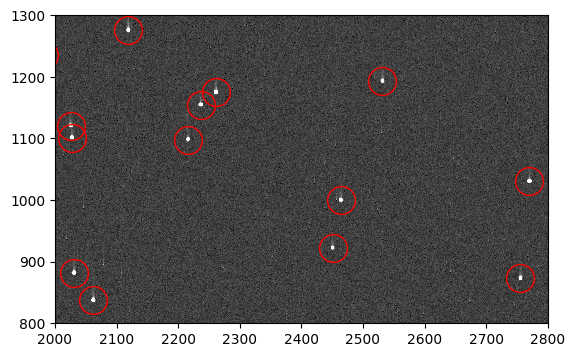

In [49]:
synth_ctefmod = fits.getdata('synth_ctefmod_rn_flt.fits', ext=1)

fig, ax = plt.subplots(1, 1, figsize=(9, 4))

ax.imshow(synth_ctefmod, vmin=0, vmax=200, interpolation='nearest', cmap='Greys_r', 
          origin='lower')
ax.plot(sources['x_mean'], sources['y_mean'], marker='o', markersize=20, 
        markerfacecolor='none', markeredgecolor='red', linestyle='none')

ax.set_xlim(2000, 2800)
ax.set_ylim(800, 1300)

(800.0, 1300.0)

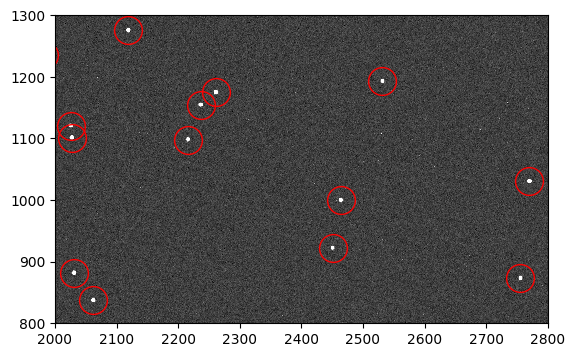

In [50]:
synth_ctefmod_flc = fits.getdata('synth_ctefmod_rn_flc.fits', ext=1)

fig, ax = plt.subplots(1, 1, figsize=(9, 4))

ax.imshow(synth_ctefmod_flc, vmin=0, vmax=200, interpolation='nearest', cmap='Greys_r', 
          origin='lower')
ax.plot(sources['x_mean'], sources['y_mean'], marker='o', markersize=20, 
        markerfacecolor='none', markeredgecolor='red', linestyle='none')

ax.set_xlim(2000, 2800)
ax.set_ylim(800, 1300)

### For more help:

More details may be found on the [ACS website](http://www.stsci.edu/hst/instrumentation/acs) and in the [ACS Instrument](https://hst-docs.stsci.edu/display/ACSIHB) and [Data Handbooks](http://www.stsci.edu/files/live/sites/www/files/home/hst/instrumentation/acs/documentation/other-documents/_documents/acs_dhb.pdf).

Please visit the [HST Help Desk](http://hsthelp.stsci.edu). Through the help desk portal, you can explore the HST Knowledge Base and request additional help from experts.

<a id="about_ID"></a>
### About this Notebook
**Author:** Jenna Ryon, ACS Instrument Team <br>
**Updated On:** 04/21/2022

---

[Top of Page](#title_ID)
<img style="float: right;" src="https://raw.githubusercontent.com/spacetelescope/notebooks/master/assets/stsci_pri_combo_mark_horizonal_white_bkgd.png" alt="Space Telescope Logo" width="200px"/> 
<br></br>
<br></br>